In [1]:
# %matplotlib widget
%matplotlib inline
# %matplotlib qt5

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
from scipy.fft import fft, fftfreq
import json
from copy import deepcopy

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# style.use('default')
style.use('S:\Connie\prx.mplstyle')

import Pyro4.util

# Load experiments

In [ ]:
# %aimport experiments
import experiments as meas

In [4]:
"""Reopen saved data"""
def prev_data(expt_path, filename=None):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [ ]:
data_path = 'S:\\QRAM\\qram_4QR2\\'
expt_path = os.path.join(data_path, 'data', 'data_241025')
print('Data will be stored in', expt_path)

In [ ]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)
print('Config will be', config_path)

# Set the qubits/resonators to probe

## [Auto0] SET 2Q QUBIT SWAP PARAMETERS

In [7]:
qubits = [2, 1] # order doesn't matter if you specify qDrive correctly
init_state = '|0>|1>'
wrong_init_state = '|1>|1>'
setup_ZZ = None
# measure_qubits = [qubits[0], qubits[1], 3]
measure_qubits = qubits
qDrive = qubits[0] # normal new protocol

# qubits = [3, 1] # order doesn't matter if you specify qDrive correctly
# init_state = '|1>|1>' # for everything else
# wrong_init_state = '|0>|1>'
# setup_ZZ = 0 # for the amp rabi chevron
# # measure_qubits = [qubits[0], qubits[1], 2]
# measure_qubits = qubits
# qDrive = qubits[0] # normal new protocol

# init_state = '|0>|2>'
# qDrive = qubits[1]


# f0-g1
# # init_state = '|0>|0>'
# # qDrive = 1 # resonator f0-g1

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [8]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [9]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
# im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium
im = InstrumentManager(ns_address='10.108.30.75') # Spilker Vibranium

In [ ]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

In [ ]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# TURN OFF
lo1.set_standby(True)
lo1.set_output_state(False)

# # TURN ON
# lo1.set_standby(False)
# lo1.set_output_state(True)
# lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
# lo_power = float(yaml_cfg.hw.lo.readout.power)
# lo1.set_frequency(lo_freq) # Set LO frequency
# print('set freq to', lo_freq)
# lo1.set_power(lo_power) # Set LO power
# print('set power to', lo_power)

# ZZ shifted pi pulses

## Pulse probe coupling spectroscopy

Sweep qubit A frequency after applying pi pulse to qubit B.

In [101]:
qubits = [1, 2] # for eg-gf swap, always list the 2nd qubit here as the 2nd qubit in the order eg-gf

In [ ]:
qZZspec = meas.PulseProbeCouplingSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_coupling_spectroscopy_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span = 1
npts = 100

qZZspec.cfg.expt = dict(
    start=qZZspec.cfg.device.qubit.f_Q1_ZZ[qubits[1]]-span/2,
    # start=qZZspec.cfg.device.qubit.f_ge[qubits[0]]-span/2,
    # start=3458.5-span/2,
    step=span/npts,
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=10, # Number of start to finish sweeps to average over
    pulseB=True, # Whether to apply pi pulse to qubit B
    length=1, # qubit 0 probe constant pulse length [us]
    gain=100, # qubit 0 const pulse gain
    pulse_type='gauss',
    qubits=qubits,
)

# qZZspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]

print(qZZspec.cfg)

qZZspec.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# qZZspec = meas.PulseProbeEgGfSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00002_qubit_coupling_spectroscopy_qubit01.h5')
# data = qZZspec.analyze(data=temp_data, fit=True, sign=[[1, -1], [-1, -1]])
# qZZspec.display(data=data, fit=True)

qZZspec.analyze(fit=True, signs=[1, -1, 1])
qZZspec.display(fit=True, signs=[1, -1, 1])

In [ ]:
qZZspec.save_data()

## Length rabi for Q1 with QA in e

In [ ]:
lengthrabiZZ = meas.LengthRabiPiZZExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_ZZ_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

lengthrabiZZ.cfg.expt = dict(
    start=0, # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=101,
    reps=1000,
    gain=20000, # qubit gain [DAC units],
    pulse_type='gauss',
    qubits=qubits,
)
# lengthrabiZZ.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

print(lengthrabiZZ.cfg)
# lengthrabi.im[lengthrabi.cfg.aliases.soc].reset()
lengthrabiZZ.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabiZZ.analyze(data=temp_data, fit=True)

lengthrabiZZ.analyze(fit=True)
lengthrabiZZ.display(fit=True)

In [ ]:
lengthrabiZZ.save_data()

# 2Q swap frequencies

Estimate 2Q swap frequencies analytically

In [ ]:
f_ge = np.array(yaml_cfg.device.qubit.f_ge) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)
f_Q1_ZZ = np.array(yaml_cfg.device.qubit.f_Q1_ZZ) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)
f_ef = np.array(yaml_cfg.device.qubit.f_ef) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)

print('f_EgGf: need indices 0, 2, 3')
print(f_ge[1] + f_ef[1] - f_ge)
print('f_EgGf_Q: indices 2, 3')
print(f_ge[2] + f_ef[2] - f_ge[1])
print(f_ge[3] + f_ef[3] - f_Q1_ZZ[0])
print('f_EgGf for Q3 if switch is in g')
print(f_ge[3] + f_ef[3] - f_ge[1])
print('f_EgGf for Q2 if switch is in 3')
print(f_ge[2] + f_ef[2] - f_Q1_ZZ[0])

## Pulse probe eg-gf spectroscopy

In [ ]:
qEgGfspec = meas.PulseProbeEgGfSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EgGf_spectroscopy_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span = 40
npts = 150

qEgGfspec.cfg.expt = dict(
    # start=qEgGfspec.cfg.device.qubit.f_ge[1] - span/2, # Eg-Gf probe frequency [MHz]
    start=qEgGfspec.cfg.device.qubit.f_EgGf[qubits[0]] - span/2, # Eg-Gf probe frequency [MHz]
    # start=1900,
    step=span/npts,
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=10, # Number of start to finish sweeps to average over
    length=2, # Eg-Gf probe constant pulse length [us]
    gain=3000, # Eg-Gf const pulse gain
    qubits=qubits,
)
# qEgGfspec.cfg.device.readout.relax_delay = [50]*4
# qEgGfspec.cfg.device.readout.relax_delay = [100, 100, 100, 100]
# qEgGfspec.cfg.device.readout.length = [5, 5, 5, 5]

print(qEgGfspec.cfg)

qEgGfspec.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# qEgGfspec = meas.PulseProbeEgGfSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00002_qubit_EgGf_spectroscopy_qubit01.h5')
# data = qEgGfspec.analyze(data=temp_data, fit=True, sign=[[1, -1], [-1, -1]])
# qEgGfspec.display(data=data, fit=True)

# qEgGfspec.analyze(fit=False)
sign = [[1, -1], [-1, 1]] # [iA, qA], [iB, qB]
qEgGfspec.analyze(fit=True, sign=sign)
qEgGfspec.display(fit=True, sign=sign)

In [ ]:
qEgGfspec.save_data()

### Pulse probe EgGF power sweep

In [ ]:
sweepspecEgGf = meas.PulseProbeEgGfSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"pulse_probe_ef_len_sweep_spectroscopy_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span_f = 75
npts_f = 150
# npts_f = 10

span_len = 20
npts_len = 10
# npts_len = 3

sweepspecEgGf.cfg.expt = dict(
    start_f=sweepspecEgGf.cfg.device.qubit.f_EgGf[qubits[0]] - span_f/2, # Eg-Gf probe frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    start_len=1,
    step_len=int(span_len/npts_len), # len step size
    expts_len=npts_len, # Number experiments stepping len from start
    reps=500,
    rounds=40, # Number averages per point
    gain=30000, # ef const pulse length [us]
    qubits=qubits,
)
sweepspecEgGf.cfg.device.readout.relax_delay = [100, 100, 100, 100]
sweepspecEgGf.cfg.device.readout.length = [5, 5, 5, 5]
sweepspecEgGf.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

sweepspecEgGf.analyze()
sweepspecEgGf.display()

In [ ]:
3452+3318-4763

## [Auto1] Rabi eg-gf chevron (freq vs. amplitude)

In [ ]:
rabiEgGfFreqGainChevron = meas.EgGfFreqGainChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rabi_EgGf_freqgain_chevron_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span_gain = 25000
# span_gain = 7000
# npts_gain = 10
# span_gain = 0
# npts_gain = 25
npts_gain = 15

# span_f = 26 # MHz
# npts_f = 50
span_f = 14
npts_f = 25

rabiEgGfFreqGainChevron.cfg.expt = dict(
    start_gain=7000, # qubit gain [dac level]
    # start_gain=18000, # qubit gain [dac level]
    step_gain=int(span_gain/npts_gain), # [dac level]
    expts_gain=npts_gain,
    # start_f=2012 - span_f/2, # start freq [MHz],
    # start_f=rabiEgGfFreqGainChevron.cfg.device.qubit.f_EgGf[qubits[0]] - span_f/2, # start freq [MHz],
    # start_f=rabiEgGfFreqGainChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]] - span_f/2, # start freq [MHz],
    # start_f=rabiEgGfFreqGainChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]] - 5 - span_f/2, # start freq [MHz],
    start_f=5877,
    step_f=span_f/npts_f, # freq step, 
    expts_f=npts_f, # number of different freq experiments, 
    reps=40,
    rounds=10,
    pi_EgGf_sigma=0.400, # gaussian sigma/const pulse length, overrides config [us]
    pulse_type='flat_top',
    # pulse_type='const',
    setup_ZZ=setup_ZZ,
    # setup_ZZ=None,
    qDrive=qDrive,
    # qDrive=1,
    qubits=qubits,
    measure_qubits=measure_qubits,

    test_pi_half=True,


    # full_mux_expt=True,
    # resonator_reset=[0, 2, 3],
)

# rabiEgGfFreqGainChevron.cfg.device.readout.readout_length = [15, 15] # [us]
# rabiEgGfFreqGainChevron.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

print('qDrive', qDrive)
print(rabiEgGfFreqGainChevron.cfg)

rabiEgGfFreqGainChevron.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# rabiEgGfFreqGainChevron = meas.EgGfFreqGainChevronExperiment(config_file=config_path)
# temp_data, attrs = prev_data('s:\QRAM\qram_4QR2\data\data_240508\\00001_rabi_EgGf_freqgain_chevron_qubit31.h5')
# rabiEgGfFreqGainChevron.cfg.expt = attrs['config']['expt']
# # print(temp_data.keys())
# # rabiEgGfFreqGainChevron.display(data=temp_data, saveplot=True) #, plot_freq=2024.5, plot_gain=2125)
# data = rabiEgGfFreqGainChevron.analyze(data=temp_data, fit=True)
# rabiEgGfFreqGainChevron.display(data=data, fit=True)

data = rabiEgGfFreqGainChevron.analyze(data=None, fit=True)
rabiEgGfFreqGainChevron.display(fit=True, data=data, range_start=3, range_end=-1) #, plot_freq=5883.9, plot_gain=21000)


plt.figure()
plot_gain = 15000
# plot_gain = rabiEgGfFreqGainChevron.cfg.device.qubit.pulses.pi_EgGf_Q.gain[qubits[0]]
gain_ind = np.argmin(np.abs(data['gainpts']-plot_gain))
# for i in range(len(data['lenpts'])):
#     plt.plot(data['freqpts'], data['avgi'][0][:, i])

amps_freq_cut_qA = data['amps'][0][:, gain_ind]
amps_freq_cut_qB = data['amps'][1][:, gain_ind]

p_ampsA = data['fitamps'][0][gain_ind]
# print(p_ampsA)
fit_amps_freq_cut_qA = meas.fitting.rabifunc(data['freqpts'], *p_ampsA)
plt.suptitle(f"Cut through gain {data['gainpts'][gain_ind]} us")
plt.subplot(211, title=f'QA ({qubits[0]})')
plt.plot(data['freqpts'], amps_freq_cut_qA, '.-', label='qA', color=default_colors[0])
plt.plot(data['freqpts'], fit_amps_freq_cut_qA, color=default_colors[0])
# plt.axvline(freq_max_amp_qA, color=default_colors[0], linestyle='--')
plt.ylabel('Amplitude [ADC units]')

plt.subplot(212, title=f'QB ({qubits[1]})')
plt.plot(data['freqpts'], amps_freq_cut_qB, '.-', label='qB', color=default_colors[1])
# plt.plot(data['freqpts'], meas.fitting.quadraticfunc(data['freqpts'], *p_ampsB), color=default_colors[1])
# plt.axvline(freq_min_amp_qB, color=default_colors[1], linestyle='--')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Amplitude [ADC units]')
plt.tight_layout()
plt.show()


In [ ]:
rabiEgGfFreqGainChevron.save_data()

## Length rabi chevron eg-gf (freq vs. len)

1. Once picked a good gain/len/freq, make sure the freq is really dialed in by doing a cut through the length.
2. Calibrate simultaneous pulses by doing the same thing while playing the other pulse

In [ ]:
rabiEgGfFreqLenChevron = meas.EgGfFreqLenChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rabi_EgGf_freqlen_chevron_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

# span_f = 10 # MHz
span_f = 1.5 # MHz
npts_f = 100
# npts_f = 25

# start_len = 0.0
# span_len = 1.5*rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qubits[0]]
# npts_len = 15
start_len = rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qubits[0]]
span_len = 0
npts_len = 1

print(measure_qubits)
print(qubits)
  
rabiEgGfFreqLenChevron.cfg.expt = dict(
    # start_f=rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf[qubits[0]] - span_f/2 - 20, # start freq [MHz],
    start_f=rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]] - 0.5*span_f, # start freq [MHz],
    step_f=span_f/npts_f, # freq step, 
    expts_f=npts_f+1, # number of different freq experiments, 
    start_len=start_len, # pulse length (sigma) [us]
    step_len=span_len/npts_len, # [us]
    expts_len=npts_len,
    # gain=30000,
    # reps=800,
    reps=2000,
    loops=1,
    pulse_type='flat_top',
    post_process=None, #'threshold',
    # singleshot_reps=10000,
    # sigma_ramp_cycles=10,
    measure_f=None,
    init_state=init_state,
    qDrive=qDrive,
    qubits=qubits,
    measure_qubits=measure_qubits,

    # qubits_simulswap=[2, 1],
    # qDrive_simul=2,
)

# rabiEgGfFreqLenChevron.cfg.device.readout.readout_length = [15, 15] # [us]
# rabiEgGfFreqLenChevron.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

print(rabiEgGfFreqLenChevron.cfg)

try:
    rabiEgGfFreqLenChevron.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
data = rabiEgGfFreqLenChevron.analyze(data=None, fit=False)
rabiEgGfFreqLenChevron.display(data=data, fit=False, signs=[-1, -1, -1, 1])

rabiEgGfFreqLenChevron.data = data

# print('Saved', rabiEgGfFreqLenChevron.save_data())

plt.figure(figsize=(9, 8))
if qubits[0] == 3: sign = 1
elif qubits[0] == 2: sign = -1
good_ZZ_freq = rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]]
# bad_ZZ_freq = rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]]+sign*rabiEgGfFreqLenChevron.cfg.device.qubit.ZZs[1]

plot_len = rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qubits[0]]
# plot_len = rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf.sigma[qubits[0]]
len_ind = np.argmin(np.abs(data['lenpts']-plot_len))
# for i in range(len(data['lenpts'])):
#     plt.plot(data['freqpts'], data['avgi'][0][:, i])

amps_freq_cut_qA = data['amps'][0][:, len_ind]
amps_freq_cut_qB = data['amps'][1][:, len_ind]
p_ampsA, pCov_ampsA = meas.fitting.fitquadratic(data['freqpts'], amps_freq_cut_qA)
p_ampsB, pCov_ampsB = meas.fitting.fitquadratic(data['freqpts'], amps_freq_cut_qB)
fit_amps_freq_cut_qA = meas.fitting.quadraticfunc(data['freqpts'], *p_ampsA)
fit_amps_freq_cut_qB = meas.fitting.quadraticfunc(data['freqpts'], *p_ampsB)
freq_max_amp_qA = data['freqpts'][np.argmax(fit_amps_freq_cut_qA)]
freq_min_amp_qB = data['freqpts'][np.argmin(fit_amps_freq_cut_qB)]
print('QA freq with max amp', freq_max_amp_qA)
print('QB freq with min amp', freq_min_amp_qB)
plt.suptitle(f"Cut through length {data['lenpts'][len_ind]:.3} us")
plt.subplot(211, title=f'QA ({qubits[0]})')
plt.plot(data['freqpts'], amps_freq_cut_qA, '.-', label='qA', color=default_colors[0])
plt.plot(data['freqpts'], fit_amps_freq_cut_qA, color=default_colors[0])
plt.axvline(freq_max_amp_qA, color=default_colors[0], linestyle='--')
plt.ylabel('Amplitude [ADC units]')

plt.subplot(212, title=f'QB ({qubits[1]})')
plt.plot(data['freqpts'], amps_freq_cut_qB, '.-', label='qB', color=default_colors[1])
plt.plot(data['freqpts'], meas.fitting.quadraticfunc(data['freqpts'], *p_ampsB), color=default_colors[1])
plt.axvline(freq_min_amp_qB, color=default_colors[1], linestyle='--')
# plt.axvline(5890.45, color='r', linestyle='--')
# plt.axvline(bad_ZZ_freq, color='r', linestyle='--')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Amplitude [ADC units]')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(data['freqpts'], amps_freq_cut_qA+amps_freq_cut_qB, '.-', label='qA+qB', color=default_colors[0])


In [ ]:
filename = 's:\Connie\experiments\qramLL_4QR2\data\data_240218\\00123_rabi_EgGf_freqlen_chevron_qubit21.h5'
# filename = 's:\Connie\experiments\qramLL_4QR2\data\data_240218\\00025_rabi_EgGf_freqlen_chevron_qubit31.h5'

rabiEgGfFreqLenChevron = meas.EgGfFreqLenChevronExperiment(
    soccfg=None,
    path=expt_path,
    prefix=f"rabi_EgGf_freqlen_chevron_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)
temp_data, attrs = prev_data(filename, None)
data = temp_data
data = deepcopy(data)

# # print(temp_data['amps'].shape)
# # print(data['amps'].shape)
# for fit_axis in ['amps', 'avgi', 'avgq']:
#     data[fit_axis] = np.concatenate((temp_data[fit_axis], data[fit_axis]), axis=1)
# data['freqpts'] = np.concatenate((temp_data['freqpts'], data['freqpts']), axis=None)

# print(data['freqpts'])
# rabiEgGfFreqLenChevron.display(data=data, fit=False, signs=[-1, 1, -1, 1])

rabiEgGfFreqLenChevron.data = data
rabiEgGfFreqLenChevron.cfg = AttrDict(attrs['config'])
qubits = rabiEgGfFreqLenChevron.cfg.expt.qubits
if qubits[0] == 3: sign = 1
elif qubits[0] == 2: sign = -1
good_ZZ_freq = rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]]
bad_ZZ_freq = rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]]+sign*rabiEgGfFreqLenChevron.cfg.device.qubit.ZZs[1]

plt.style.use('dark_background')

rows = 2
cols = 1
index = rows*100 + cols*10
fig, axs = plt.subplots(rows, cols, figsize=(9*cols, 7), gridspec_kw={'height_ratios': [1, 1]}, sharex='col')
ax1, ax2 = axs
plt.suptitle("$|eg\\rangle-|gf\\rangle$"+ f" Frequency vs. Length (Q{qubits[0]}/Q{qubits[1]})")

plt.sca(ax1)
data['amps'][0] = (data['amps'][0] - min(data['amps'][0])) / (max(data['amps'][0]) - min(data['amps'][0]))
rabiEgGfFreqLenChevron.plot_rabi_chevron(data, 'amps', plot_xpts=1000*data['lenpts'], plot_ypts=data['freqpts'], plot_rabi=False, q_index=0, show_cbar=False)
# plt.axhline(bad_ZZ_freq, color='r', linestyle='--')
# print(((data['freqpts'][-1] - data['freqpts'][0])//4))
# yticks = int(np.average(data['freqpts'])) + (data['freqpts'][-1] - data['freqpts'][0])//3*np.arange(-1, 2) 
yticks = [round(good_ZZ_freq), round(bad_ZZ_freq)] 
plt.yticks(ticks=yticks, fontsize=24)
plt.ylabel('Frequency\n(MHz)', fontsize=24)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax, ticks=[0, 0.5, 1])
cbar.ax.tick_params(labelsize=16)
cbar.set_label(f'Population (Scaled)', size='large')
# cbar.ax.set_title(f'Q{qubits[0]}')

plt.sca(ax2)
# data['amps'][1] = (data['amps'][1] - min(data['amps'][1])) / (max(data['amps'][1]) - min(data['amps'][1]))
data['amps'][1] = (data['amps'][1] - max(data['amps'][1])) / (min(data['amps'][1]) - max(data['amps'][1]))
rabiEgGfFreqLenChevron.plot_rabi_chevron(data, 'amps', plot_xpts=1000*data['lenpts'], plot_ypts=data['freqpts'], plot_rabi=False, q_index=1, show_cbar=False)
# plt.axhline(bad_ZZ_freq, color='r', linestyle='--')
# yticks = int(np.average(data['freqpts'])) + (data['freqpts'][-1] - data['freqpts'][0])//3*np.arange(-1, 2) 
yticks = [round(good_ZZ_freq), round(bad_ZZ_freq)] 
plt.ylabel('Frequency\n(MHz)', fontsize=24)
plt.xlabel('Length (ns)', fontsize=24)
plt.yticks(ticks=yticks, fontsize=24)
plt.xticks(fontsize=24)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax, ticks=[0, 0.5, 1])
cbar.ax.tick_params(labelsize=16)
cbar.set_label(f'Population (Scaled)', size='large')
# cbar.ax.set_title(f'Q{qubits[1]}')

plt.subplots_adjust(hspace=0.07)
# plt.tight_layout()

plot_filename = filename[:-3]+'.svg'
plt.savefig(plot_filename, format='svg', bbox_inches='tight', transparent=True)
print('Saved', plot_filename)

plt.show()




# # filename = 's:\Connie\experiments\qramLL_4QR2\data\data_240218\\00122_rabi_EgGf_freqlen_chevron_qubit21.h5'
# # temp_data, attrs = prev_data(filename, None)
# # data = temp_data
# # data = deepcopy(data)

# # # print(temp_data['amps'].shape)
# # # print(data['amps'].shape)
# # for fit_axis in ['amps', 'avgi', 'avgq']:
# #     data[fit_axis] = np.concatenate((temp_data[fit_axis], data[fit_axis]), axis=1)
# # data['freqpts'] = np.concatenate((temp_data['freqpts'], data['freqpts']), axis=None)

# # print(data['freqpts'])
# # rabiEgGfFreqLenChevron.display(data=data, fit=False, signs=[-1, 1, -1, 1])

# rabiEgGfFreqLenChevron.data = data
# rabiEgGfFreqLenChevron.cfg = AttrDict(attrs['config'])
# qubits = rabiEgGfFreqLenChevron.cfg.expt.qubits
# if qubits[0] == 3: sign = 1
# elif qubits[0] == 2: sign = -1
# good_ZZ_freq = rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]]
# bad_ZZ_freq = rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]]+sign*rabiEgGfFreqLenChevron.cfg.device.qubit.ZZs[1]

# plot_len = rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qubits[0]]
# len_ind = np.argmin(np.abs(data['lenpts']-plot_len))


# fig, axs = plt.subplots(rows, cols, figsize=(6*cols, 7), gridspec_kw={'height_ratios': [1, 1]}, sharex='col')
# ax1, ax2 = axs
# plt.suptitle(f"Q{qubits[0]} Cut Through Length {data['lenpts'][len_ind]:.3} ns")

# plt.sca(ax1)
# data['amps'][0] = (data['amps'][0] - min(data['amps'][0])) / (max(data['amps'][0]) - min(data['amps'][0]))
# plt.plot(data['freqpts'], data['amps'][0][:, len_ind], '.-')
# # plt.axvline(bad_ZZ_freq, color='r', linestyle='--')
# plt.ylabel('Population\n(Scaled)', fontsize=24)
# plt.yticks(ticks=[0, 0.5, 1.0], fontsize=24)

# plt.sca(ax2)
# data['amps'][1] = (data['amps'][1] - min(data['amps'][1])) / (max(data['amps'][1]) - min(data['amps'][1]))
# plt.plot(data['freqpts'], data['amps'][1][:, len_ind], '.-')
# # plt.axvline(bad_ZZ_freq, color='r', linestyle='--')
# plt.ylabel('Population\n(Scaled)', fontsize=24)
# plt.xlabel('Frequency (MHz)', fontsize=24)
# plt.yticks(ticks=[0, 0.5, 1.0], fontsize=24)
# # xticks = int(np.average(data['freqpts'])) + (data['freqpts'][-1] - data['freqpts'][0])//3*np.arange(-1, 2) 
# xticks = [round(good_ZZ_freq), round(bad_ZZ_freq)] 
# plt.xticks(ticks=xticks, fontsize=24)

# plt.subplots_adjust(hspace=0.07)

# plot_filename = filename[:-3]+f'_cut.svg'
# plt.savefig(plot_filename, format='svg', bbox_inches='tight', transparent=True)
# print('Saved', plot_filename)

# plt.show()

## Length Rabi eg-gf single sweep

In [ ]:
lengthrabiEgGf = meas.LengthRabiEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

# start_len = lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
# span_len = 0
# npts_len = 10

start_len = 0
# span_len = 3.75*lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
span_len = 1*lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
npts_len = 30
# start_len = 0.999*lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
# span_len = 0.001*lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
# npts_len = 50


lengthrabiEgGf.cfg.expt = dict(
    start=start_len, # pulse length (sigma) [us]
    # step=0,
    # expts=1,
    step=span_len/npts_len, # [us]
    expts=npts_len+1,
    reps=2000,
    # reps_f=25000,
    # reps_f=1000,
    # reps=4000,
    # loops=5,
    pulse_type='flat_top',
    post_process=None,
    # post_process=None,
  
    # singleshot_reps=40000,
    # singleshot_reps=1000,
    measure_f=None,
    # measure_f=[qDrive],
    init_state=init_state,
    # init_state=wrong_init_state,
    qDrive=qDrive,
    qubits=qubits,
    measure_qubits=measure_qubits,

    test_pi_half=True,
    readout_cool=False,

    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,
)

# lengthrabiEgGf.cfg.device.readout.readout_length = [10,5] # [us]
print(lengthrabiEgGf.cfg)
# lengthrabiEgGf.im[lengthrabiEgGf.cfg.aliases.soc].reset()
try:
    lengthrabiEgGf.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
lengthrabiEgGf.save_data()

In [ ]:
# # TESTING
# lengthrabiEgGf = meas.LengthRabiEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_length_rabi_qubit01.h5')
# data = lengthrabiEgGf.analyze(data=temp_data, fit=True)
# lengthrabiEgGf.display(data=data, fit=False)

lengthrabiEgGf.analyze(fit=True, post_select_calib=False, post_select_experiment=False, separate_correction=False, ps_qubits=[0, 1, 2], verbose=False)

# plt.figure()
# print(lengthrabiEgGf.cfg.expt.measure_qubits)
# plt.plot(lengthrabiEgGf.data['xpts'], lengthrabiEgGf.data['amps'][0], label='q1')
# plt.plot(lengthrabiEgGf.data['xpts'], lengthrabiEgGf.data['amps'][1], label='q2')
# plt.ylabel('rotated amplitude')
# plt.legend()
# plt.show()

# plt.figure()
# # 00, 01, 10, 11
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 2], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 3], axis=0), label='q1 e counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 1], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 3], axis=0), label='q2 e counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 0], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 2], axis=0), label='q2 g counts')
# plt.ylabel('counts measurement 0')
# plt.legend()
# plt.show()

# plt.figure()
# # 00, 02, 10, 12
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 2], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 3], axis=0), label='q1 e counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 1], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 3], axis=0), label='q2 f counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 0], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 2], axis=0), label='q2 g counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 1], axis=0), label='gf counts')
# plt.ylabel('counts measurement 1')
# plt.legend()
# plt.show()

lengthrabiEgGf.display(fit=True)

# print(lengthrabiEgGf.data['counts_calib'])

### Length rabi with post selection

In [ ]:
lengthrabiEgGf = meas.LengthRabiEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

# start_len = lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
# span_len = 0
# npts_len = 10

start_len = 0
# span_len = 3.75*lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
span_len = 1.0*lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
# npts_len = 15
# start_len = 0.999*lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
# span_len = 2*lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
# npts_len = 50
npts_len = 1

lengthrabiEgGf.cfg.expt = dict(
    start=start_len, # pulse length (sigma) [us]
    # step=0,
    # expts=1,
    step=span_len/npts_len, # [us]
    expts=npts_len+1,
    reps=20000,
    # reps_f=20000,
    # reps=100,
    reps_f=10,
    loops=1,
    pulse_type='flat_top',
    post_process='threshold',
    # post_process=None,
  
    # singleshot_reps=500,
    singleshot_reps=20000,
    singleshot_reps_f=10,
    # singleshot_reps=100,
    # measure_f=None,
    measure_f=[qDrive],
    init_state=init_state,
    # init_state='test',
    # init_state='|1+0>|1>',
    # init_state='|1>|0+1>',
    # init_state='Q2Q1_|2>|0>',
    qDrive=qDrive,
    qubits=qubits,
    measure_qubits=measure_qubits,
    
    # setup_measure='qDrive_ef',

    test_pi_half=False,
    # cool_qubits=[0, 1],
    # cool_idle=[5, 5],
    
    readout_cool=True,
    n_init_readout=1,
    n_trig=1,
    init_read_wait_us=2,

    resonator_reset=[0, 2, 3],
    full_mux_expt=True,

    use_robust_pulses=True,

    n_cycles=3,
    skip_first_pi2=True,
    # plot_IQ=True,
    # init_read_wait_us=2,
    # use_gf_readout=True,
    
    # thresholds=[0, 403.4255711140312, 356.93670935384887, 0],
    # angles=[0, -15.164283291744868, 107.2178024864672, 0],
    # ge_avgs=[array([0., 0., 0., 0.]), [332.72639357096347, -312.0792793945312, 663.0205369628906, -231.3194316731771], [-55.472186757526444, -160.28748716436127, -169.05275673311635, -537.4039020748576], array([0., 0., 0., 0.])],
    # counts_calib=[[16091, 2293, 1360, 256], [2287, 16108, 208, 1397], [2399, 307, 14988, 2306], [414, 2510, 2206, 14870]]

)

lengthrabiEgGf.cfg.device.readout.gain[1] = 1e-4

print(lengthrabiEgGf.cfg)
# lengthrabiEgGf.im[lengthrabiEgGf.cfg.aliases.soc].reset()
try:
    lengthrabiEgGf.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
lengthrabiEgGf.save_data()

In [ ]:
# # TESTING
# lengthrabiEgGf = meas.LengthRabiEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_length_rabi_qubit01.h5')
# lengthrabiEgGf.data = temp_data
# lengthrabiEgGf.cfg = AttrDict(attrs['config'])
# data = lengthrabiEgGf.analyze(data=temp_data, fit=True)
# lengthrabiEgGf.display(data=data, fit=False)

ps_qubits = [0, 2, 3]

ps_adjust = [-0.1, np.inf, -0.1, -0.1]

# ps_adjust = [-1.2, -1.0, -1.7, 0.0]
# ps_adjust_f = [-1.0, -1.0, -1.0, 0.0]
# ps_adjust_f = [-1, -1, np.inf, -1]
ps_adjust_f = [np.inf]*4

# ps_adjust = [np.inf]*4
# ps_adjust = None

apply_ps = True

# lengthrabiEgGf.analyze(fit=False, post_select_calib=apply_ps, post_select_experiment=apply_ps, separate_correction=False, ps_qubits=ps_qubits, ps_adjust=ps_adjust, ps_adjust_f=ps_adjust_f)

# lengthrabiEgGf.display(fit=False)

# plt.figure()
# print(lengthrabiEgGf.cfg.expt.measure_qubits)
# plt.plot(lengthrabiEgGf.data['xpts'], lengthrabiEgGf.data['amps'][0], label='q1')
# plt.plot(lengthrabiEgGf.data['xpts'], lengthrabiEgGf.data['amps'][1], label='q2')
# plt.ylabel('rotated amplitude')
# plt.legend()
# plt.show()

# plt.figure()
# # 00, 01, 10, 11
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 2], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 3], axis=0), label='q1 e counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 1], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 3], axis=0), label='q2 e counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 0], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 2], axis=0), label='q2 g counts')
# plt.ylabel('counts measurement 0')
# plt.legend()
# plt.show()

# plt.figure()
# # 00, 02, 10, 12
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 2], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 3], axis=0), label='q1 e counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 1], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 3], axis=0), label='q2 f counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 0], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 2], axis=0), label='q2 g counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 1], axis=0), label='gf counts')
# plt.ylabel('counts measurement 1')
# plt.legend()
# plt.show()


data = lengthrabiEgGf.data
histdata = dict(iqshots=[])
check_states = []
# gg, ge, eg, ee, gf, ef q1/q2(q3), g(q0), e(q0), g(q2/3), e(q2/3)
loop = 0
imeasure = 0
ilen = -1

q = 2
if q in [2, 3]:
    if lengthrabiEgGf.measure_f:
        if q == lengthrabiEgGf.cfg.expt.measure_f[0]:
            iprep_g = 0
            iprep_e = 1
            iprep_f = 4
        else:
            iprep_g = 8
            iprep_e = 9
            iprep_f = None
    else:
        iprep_g = 0
        iprep_e = 2
        iprep_f = None
elif q == 1:
    iprep_g = 0
    iprep_e = 2
    iprep_f = None
elif q == 0:
    iprep_g = 6
    iprep_e = 7
    iprep_f = None


histdata['iqshots'].append((data[f'calib_ishots_raw_loops'][loop, imeasure, iprep_g, :, -1, :], data[f'calib_qshots_raw_loops'][loop, imeasure, iprep_g, :, -1, :]))
check_states.append('g')
histdata['iqshots'].append((data[f'calib_ishots_raw_loops'][loop, imeasure, iprep_e, :, -1, :], data[f'calib_qshots_raw_loops'][loop, imeasure, iprep_e, :, -1, :]))
check_states.append('e')
if q in [2, 3] and lengthrabiEgGf.measure_f and q == lengthrabiEgGf.cfg.expt.measure_f[0]:
    histdata['iqshots'].append((data[f'calib_ishots_raw_loops'][loop, imeasure, iprep_f, :, -1, :], data[f'calib_qshots_raw_loops'][loop, imeasure, iprep_f, :, -1, :]))
    check_states.append('f')
histdata['iqshots'].append((data[f'ishots_raw_{imeasure}'][loop, ilen, :, -1, :], data[f'qshots_raw_{imeasure}'][loop, ilen, :, -1, :]))
check_states.append('test')

if lengthrabiEgGf.cfg.expt.readout_cool:
    histdata['iqshots'].append((data[f'calib_ishots_raw_loops'][loop, imeasure, iprep_g, :, 0, :], data[f'calib_qshots_raw_loops'][loop, imeasure, iprep_g, :, 0, :]))
    check_states.append('g_0')

if imeasure == 0:
    thresholds = data['thresholds_loops'][loop]
    angles = data['angles_loops'][loop]
    ge_avgs = data['ge_avgs_loops'][loop]
    if ps_adjust is None: ps_thresholds = thresholds
    else: ps_thresholds = meas.clifford_averager_program.ps_threshold_adjust(ps_thresholds_init=thresholds, adjust=ps_adjust, ge_avgs=ge_avgs, angles=angles, amplitude_mode=lengthrabiEgGf.cfg.expt.full_mux_expt)
    print('thresholds', thresholds)
    print('ps thresholds', ps_thresholds)
else:
    thresholds = data['thresholds_f_loops'][loop]
    angles = data['angles_f_loops'][loop]
    ge_avgs = data['gf_avgs_loops'][loop]
    if ps_adjust_f is None: ps_thresholds = thresholds
    else: ps_thresholds = meas.clifford_averager_program.ps_threshold_adjust(ps_thresholds_init=thresholds, adjust=ps_adjust_f, ge_avgs=ge_avgs, angles=angles, amplitude_mode=lengthrabiEgGf.cfg.expt.full_mux_expt)

_, keep_indices = meas.clifford_averager_program.post_select_shots(
    final_qubit=q,
    all_ishots_raw_q=data[f'ishots_raw_{imeasure}'][loop, ilen, :, :, :],
    all_qshots_raw_q=data[f'qshots_raw_{imeasure}'][loop, ilen, :, :, :],
    angles=angles, 
    ps_thresholds=ps_thresholds, ps_qubits=ps_qubits,
    n_init_readout=lengthrabiEgGf.cfg.expt.n_init_readout,
    post_process=None, verbose=False, return_keep_indices=True,
    amplitude_mode=lengthrabiEgGf.cfg.expt.full_mux_expt)

ishots_unrot = data[f'ishots_raw_{imeasure}'][loop, ilen, :, -1, :]
qshots_unrot = data[f'qshots_raw_{imeasure}'][loop, ilen, :, -1, :]
ishots_ps_unrot = ishots_unrot[:, keep_indices]
qshots_ps_unrot = qshots_unrot[:, keep_indices]
print('keep', 100*np.sum(keep_indices)/len(ishots_unrot[q]), '%')
if apply_ps:
    histdata['iqshots'].append((ishots_ps_unrot, qshots_ps_unrot))
    check_states.append('test_ps')

    _, g_keep_indices = meas.clifford_averager_program.post_select_shots(
        final_qubit=q,
        all_ishots_raw_q=data[f'calib_ishots_raw_loops'][loop, imeasure, iprep_g, :, :, :],
        all_qshots_raw_q=data[f'calib_qshots_raw_loops'][loop, imeasure, iprep_g, :, :, :],
        angles=angles, 
        ps_thresholds=ps_thresholds, ps_qubits=ps_qubits,
        n_init_readout=lengthrabiEgGf.cfg.expt.n_init_readout,
        post_process=None, verbose=False, return_keep_indices=True,
        amplitude_mode=lengthrabiEgGf.cfg.expt.full_mux_expt)
    g_ishots_unrot = data[f'calib_ishots_raw_loops'][loop, imeasure, iprep_g, :, -1, :]
    g_qshots_unrot = data[f'calib_qshots_raw_loops'][loop, imeasure, iprep_g, :, -1, :]
    g_ishots_ps_unrot = g_ishots_unrot[:, g_keep_indices]
    g_qshots_ps_unrot = g_qshots_unrot[:, g_keep_indices]
    histdata['iqshots'].append((g_ishots_ps_unrot, g_qshots_ps_unrot))
    check_states.append('g_ps')

    _, e_keep_indices = meas.clifford_averager_program.post_select_shots(
        final_qubit=q,
        all_ishots_raw_q=data[f'calib_ishots_raw_loops'][loop, imeasure, iprep_e, :, :, :],
        all_qshots_raw_q=data[f'calib_qshots_raw_loops'][loop, imeasure, iprep_e, :, :, :],
        angles=angles, 
        ps_thresholds=ps_thresholds, ps_qubits=ps_qubits,
        n_init_readout=lengthrabiEgGf.cfg.expt.n_init_readout,
        post_process=None, verbose=False, return_keep_indices=True,
        amplitude_mode=lengthrabiEgGf.cfg.expt.full_mux_expt)
    e_ishots_unrot = data[f'calib_ishots_raw_loops'][loop, imeasure, iprep_e, :, -1, :]
    e_qshots_unrot = data[f'calib_qshots_raw_loops'][loop, imeasure, iprep_e, :, -1, :]
    e_ishots_ps_unrot = e_ishots_unrot[:, e_keep_indices]
    e_qshots_ps_unrot = e_qshots_unrot[:, e_keep_indices]
    histdata['iqshots'].append((e_ishots_ps_unrot, e_qshots_ps_unrot))
    check_states.append('e_ps')


    if q in [2, 3] and lengthrabiEgGf.measure_f and q == lengthrabiEgGf.cfg.expt.measure_f[0]:
        _, f_keep_indices = meas.clifford_averager_program.post_select_shots(
            final_qubit=q,
            all_ishots_raw_q=data[f'calib_ishots_raw_loops'][loop, imeasure, iprep_f, :, :, :],
            all_qshots_raw_q=data[f'calib_qshots_raw_loops'][loop, imeasure, iprep_f, :, :, :],
            angles=angles, 
            ps_thresholds=ps_thresholds, ps_qubits=ps_qubits,
            n_init_readout=lengthrabiEgGf.cfg.expt.n_init_readout,
            post_process=None, verbose=False, return_keep_indices=True,
            amplitude_mode=lengthrabiEgGf.cfg.expt.full_mux_expt)
        f_ishots_unrot = data[f'calib_ishots_raw_loops'][loop, imeasure, iprep_f, :, -1, :]
        f_qshots_unrot = data[f'calib_qshots_raw_loops'][loop, imeasure, iprep_f, :, -1, :]
        f_ishots_ps_unrot = f_ishots_unrot[:, f_keep_indices]
        f_qshots_ps_unrot = f_qshots_unrot[:, f_keep_indices]
        histdata['iqshots'].append((f_ishots_ps_unrot, f_qshots_ps_unrot))
        check_states.append('f_ps')

play_pulses_list = [] # this is just so we don't print play pulses in the multihist
for check_state in check_states:
    play_pulses_list.append([0])
g_states = [0]
e_states = [1]
if imeasure == 1 and q != 1: e_states = [2]

meas.single_qubit.single_shot.multihist(
    title=f'Single Shot Q{q} with Multi Readout',
    data=histdata, check_qubit=q, check_states=check_states, play_pulses_list=play_pulses_list, g_states=g_states, e_states=e_states,
    amplitude_mode=lengthrabiEgGf.cfg.expt.full_mux_expt, plot=True, export=False, log_mode=True)

# print(lengthrabiEgGf.data['counts_calib'])

In [ ]:
I2 = lengthrabiEgGf.data['avgi'][0]
Q2 = lengthrabiEgGf.data['avgq'][0]


print('I2 min:', min(I2))
print('I2 max:', max(I2))
print('Q2 min:', min(Q2))
print('Q2 max:', max(Q2))


F0 --> G1

In [ ]:
lengthrabiF0G1 = meas.LengthRabiF0G1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_F0G1_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

start_len = 0
span_len = 1.0
npts_len = 100

lengthrabiF0G1.cfg.expt = dict(
    start=start_len, # pulse length (sigma) [us]
    step=span_len/npts_len, # [us]
    expts=npts_len,
    reps=1000,
    # gain=4250, # qubit gain [DAC units],
    pulse_type='flat_top',
    # post_process='threshold',
    post_process=None,
    # singleshot_reps=20000,
    measure_f=False,
    init_state=init_state,
    qDrive=qDrive,
    qubits=qubits,
    measure_qubits=measure_qubits,
)

# lengthrabiF0G1.cfg.device.readout.readout_length = [10,5] # [us]
print(lengthrabiF0G1.cfg)
# lengthrabiF0G1.im[lengthrabiF0G1.cfg.aliases.soc].reset()
try:
    lengthrabiF0G1.acquire(progress=True, debug=True)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# lengthrabiF0G1 = meas.LengthRabiF0G1Experiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_length_rabi_qubit01.h5')
# data = lengthrabiF0G1.analyze(data=temp_data, fit=True)
# lengthrabiF0G1.display(data=data, fit=False)

lengthrabiF0G1.analyze(fit=True)
lengthrabiF0G1.display(fit=True)
# print(lengthrabiF0G1.data['counts_calib'])

In [ ]:
lengthrabiF0G1.save_data()

## Pi Minus Pi

In [18]:
test_pi_half = True
full_mux_expt = True
resonator_reset = [0, 2, 3]

In [ ]:
piminuspi = meas.PiMinusPiEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"PiMinusPiEgGfExptQ{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

good_data = False

span_f = 2.5
# npts_f = 70
npts_f = 30 if not good_data else 75

start_f = piminuspi.cfg.device.qubit.f_EgGf_Q[qDrive]-span_f/2
if test_pi_half:
    start_f = piminuspi.cfg.device.qubit.f_EgGf_Q_half[qDrive]-span_f/2

piminuspi.cfg.expt = dict(
    start_N=0, # number gate repetitions
    step_N=1 if not good_data else 1,
    # step_N=1,
    expts_N=10 if not good_data else 20,
    start_f=start_f,
    step_f=span_f/npts_f,
    expts_f=npts_f+1,

    reps=800 if not good_data else 6000,
    loops=1,

    pulse_type='flat_top',
    post_process='scale',
    singleshot_reps=10000,
    # singleshot_reps=5000,
    measure_f=False,
    init_state=init_state,
    qDrive=qDrive,
    qubits=qubits,
    measure_qubits=measure_qubits,

    readout_cool=False,
    n_init_readout=1,
    n_trig=1,
    # init_read_wait_us=5,
    init_read_wait_us=2,

    test_pi_half=test_pi_half,
    
    full_mux_expt=full_mux_expt,
    resonator_reset=[0, 2, 3],
)
# piminuspi.cfg.device.readout.gain[1] = 1e-4

print(piminuspi.cfg)
try:
    piminuspi.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
data = piminuspi.data
piminuspi.analyze(fit=True)
piminuspi.display(fit=True)
print(piminuspi.data['best_freq'])

## Error amplification

In [ ]:
npulsecalib = meas.NPulseEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"NPulseExptEgGfQ{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

npulsecalib.cfg.expt = dict(
    start=1, # number gate repetitions
    step=1,
    expts=20,
    reps=2000,
    loops=5,

    pulse_type='flat_top',
    post_process='threshold',
    # post_process='scale',
    singleshot_reps=20000,
    measure_f=False,
    init_state=init_state,
    qDrive=qDrive,
    qubits=qubits,
    measure_qubits=measure_qubits,

    full_mux_expt=full_mux_expt,
    resonator_reset=[0, 2, 3],

    test_pi_half=False,

    # thresholds=[0, 43.41811611277916, 10.392971620466497, 0],
    # angles=[0, -101.73981388813908, 141.40196686195807, 0],
    # ge_avgs=[array([0., 0., 0., 0.]), [-17.911846226415093, 35.64949229017567, -20.07804817826936, 45.928960572543915], [-4.966982513216755, -4.092012810085401, -10.202727938186255, -8.330811813745425], array([0., 0., 0., 0.])],
    # counts_calib=[[11285, 4713, 2839, 1163], [4149, 11780, 1119, 2952], [4335, 1723, 9750, 4192], [1394, 3570, 3963, 11073]]
)

print(npulsecalib.cfg)
try:
    npulsecalib.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

data = npulsecalib.data
npulsecalib.analyze(fit=True)
npulsecalib.display(fit=True)

npulsecalib_fit, npulsecalib_fit_err = meas.fitting.get_best_fit(npulsecalib.data, prefixes=['fitA', 'fitB'], check_measures=['avgi'])

if np.all(npulsecalib_fit == data['fitA_avgi']): use_q =  npulsecalib.cfg.expt.measure_qubits[0]
else: use_q = npulsecalib.cfg.expt.measure_qubits[1]
if use_q == qDrive: sign = 1
else: sign = -1
print(use_q)
angle_err = npulsecalib_fit[1]
amp_ratio = (180 - sign*angle_err) / 180
new_opt_len = npulsecalib.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive] / amp_ratio
print(new_opt_len)

In [ ]:
npulsecalib.save_data()

## Pi pulse train

https://arxiv.org/pdf/2304.06087

In [23]:
full_mux_expt = True
resonator_reset = [0, 2, 3]
use_robust_pulses = True

test_pi_half = True

In [ ]:
train_expt = Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"eggf_train_Q{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

# span_len = 0.010
span_len = 0.020
# span_len = 0.1
npts_len = 30
start_len = train_expt.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive] - span_len/2
if test_pi_half:
    start_len = train_expt.cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[qDrive] - span_len/2
# start_len = 0.35
# start_len = 0.152 - span_len/2
len_sweep = np.linspace(start_len, start_len + span_len, npts_len+1)

print('len_sweep', len_sweep.tolist())

train_lens = [11, 21, 31] # this is the number of pi swaps
# train_lens = [4, 8] # this is the number of pi swaps
# train_lens = [3, 5, 11, 21]

train_expt.cfg.expt = dict(
    train_lens=train_lens,
    len_sweep=len_sweep,

    reps=2000,
    loops=1,

    pulse_type='flat_top',
    # post_process='threshold',
    post_process=None,
    # singleshot_reps=20000,
    measure_f=False,
    init_state=init_state,
    qDrive=qDrive,
    qubits=qubits,
    measure_qubits=measure_qubits,

    test_pi_half=test_pi_half,

    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,

    use_robust_pulses=use_robust_pulses,
)

train_expt.data = dict(
    avgi = np.zeros((2, len(train_lens), len(len_sweep))),
    avgq = np.zeros((2, len(train_lens), len(len_sweep))),
    amps = np.zeros((2, len(train_lens), len(len_sweep))),
)

thresholds = None
angles = None
ge_avgs = None
counts_calib = None

for i_npulses, npulses in enumerate(tqdm(train_lens)):
    for i_swap_len, swap_len in enumerate(tqdm(len_sweep)):
        npulsecalib = meas.NPulseEgGfExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"NPulseExptEgGfQ{qubits[0]}{qubits[1]}",
            config_file=config_path,
        )

        npulsecalib.cfg.expt = dict(
            start=npulses, # number gate repetitions
            step=0,
            expts=1,
            # thresholds=thresholds,
            # angles=angles,
            # ge_avgs=ge_avgs,
            # counts_calib=counts_calib,
            skip_first_pi2=True,
            
        )
        npulsecalib.cfg.expt.update(train_expt.cfg.expt)

        if not test_pi_half: npulsecalib.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive] = swap_len
        else: npulsecalib.cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[qDrive] = swap_len

        try:
            npulsecalib.acquire(progress=False, debug=False)
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))
        
        for data_name in ['avgi', 'avgq', 'amps']:
            for q in range(2):
                train_expt.data[data_name][q, i_npulses, i_swap_len] = npulsecalib.data[data_name][q]
        
        # thresholds = npulsecalib.data['thresholds']
        # angles = npulsecalib.data['angles']
        # ge_avgs = npulsecalib.data['ge_avgs']
        # counts_calib = npulsecalib.data['counts_calib']

In [ ]:
data_name = "amps"

for q in range(2):
    plt.figure(figsize=(8, 6))
    for i_npulses, npulses in enumerate(train_lens):
        plt.plot(len_sweep, train_expt.data[data_name][q, i_npulses, :], '.-', label=f'{npulses} pulses')
    plt.xlabel("Swap Length [us]")
    plt.ylabel(data_name)
    plt.legend()
    plt.title(f"Q{train_expt.cfg.expt.qubits[q]} {data_name}")
    plt.axvline(0.226)
    plt.show()

for q in range(2):
    plt.figure(figsize=(8, 6))
    prod = np.prod(train_expt.data[data_name][q, :, :], axis=0)
    plt.plot(len_sweep, prod, '.-')
    plt.xlabel("Swap Length [us]")
    plt.ylabel(data_name)
    plt.title(f"Product over N trains Q{train_expt.cfg.expt.qubits[q]} {data_name}")
    plt.show()


In [ ]:
print(train_expt.save_data())

## Amplitude Rabi eg-gf single sweep

In [ ]:
amprabiEgGf = meas.AmplitudeRabiEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span = 1000
npts = 101
   
amprabiEgGf.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    # step=0.001,
    rounds=10,
    reps=500,
    # pi_EgGf_sigma=0.600, # gaussian sigma/const pulse length, overrides config [us]
    pulse_type='const',
    qubits=qubits,
    singleshot=False,
)

# amprabiEgGf.cfg.device.readout.readout_length = [15, 15] # [us]
# amprabiEgGf.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

print(amprabiEgGf.cfg)

try:
    amprabiEgGf.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# amprabiEgGf = meas.AmplitudeRabiEgGfExperiment(config_file=config_path)
# amprabiEgGf.cfg.expt = dict(sigma_test=0.400, singleshot=False,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EgGf_qubit01.h5')
# data = amprabiEgGf.analyze(data=temp_data, fit=True)
# amprabiEgGf.display(data=data, fit=True)

# # apply mask onto data
# temp_data = dict()
# for key, value in amprabiEgGf.data.items():
#     if len(np.shape(value)) > 1:
#         temp_data.update({key:np.array([value[0][:50], value[1][:50]])})
#     else: temp_data.update({key:value[:50]})

amprabiEgGf.analyze(data=None, fit=True)
amprabiEgGf.display(data=None, fit=False)

In [ ]:
amprabiEgGf.save_data()

In [ ]:
prog = amprabiEgGf.prog
shot_avg = 10
threshold = amprabiEgGf.cfg.device.readout.threshold
bufi = np.array([prog.di_buf[i] for i, ch in enumerate(prog.ro_chs)])
avgi = []
for bufi_ch in bufi:
    # drop extra shots that aren't divisible into averages
    new_bufi_ch = bufi_ch[:len(bufi_ch) - (len(bufi_ch) % shot_avg)]
    # average over shots_avg number of consecutive shots
    new_bufi_ch = np.reshape(new_bufi_ch, (len(new_bufi_ch)//shot_avg, shot_avg))
    new_bufi_ch = np.average(new_bufi_ch, axis=1)
    avgi.append(new_bufi_ch)
avgi = np.array(avgi)
shots = np.array([np.heaviside(avgi[i]/prog.ro_chs[ch].length-threshold[i], 0) for i, ch in enumerate(prog.ro_chs)])

qubits = prog.cfg.expt.qubits
# get the shots for the qubits we care about
shots = np.array([shots[prog.adc_chs[q]] for q in qubits])

# data is returned as n00, n01, n10, n11 measured for the two qubits
n00 = np.sum(np.logical_and(np.logical_not(shots[0]), np.logical_not(shots[1])))
n01 = np.sum(np.logical_and(np.logical_not(shots[0]), shots[1]))
n10 = np.sum(np.logical_and(shots[0], np.logical_not(shots[1])))
n11 = np.sum(np.logical_and(shots[0], shots[1]))
print(n00, n01, n10, n11)

## [Auto2] Optimal amplitude sweep with freq + len calibration

In [ ]:
npts = 35

gain_sweep = np.linspace(7000, 32000, npts) # Q3/Q1
# gain_sweep = np.linspace(5000, 30000, npts) # Q2/Q1
print('gain_sweep\n', gain_sweep)

len_approx_gains = 1.5*np.linspace(1.00, 0.270, npts) # Q3/Q1
# len_approx_gains = 1.5*np.linspace(1.5, 0.300, npts) # Q2/Q1
print('max len for each gain (us)\n', len_approx_gains)

freq_approx_gains = meas.fitting.quadraticfunc(gain_sweep, *p)

print('approx freq for each gain\n', freq_approx_gains)
print('qubits', qubits)

opt_lens = []
opt_freqs = []
saved_files = []
save_files = True

# opt_fit_index = 1 # index of [QA I, QA Q, QB I, QB Q] to use as saved optimal
signs = [1, 1, 1, 1] # whether the period occurs at the max (1) or min (-1)

opt_fit_index = 0 # index of [QA amps, QB amps] to use as saved optimal

In [ ]:
for gain, stop_len, approx_freq in zip(gain_sweep, len_approx_gains, freq_approx_gains):
    # if gain < 27900: continue
    print('gain', gain, 'stop_len', stop_len, 'approx freq', approx_freq)
    rabiEgGfFreqLenChevron = meas.EgGfFreqLenChevronExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"rabi_EgGf_freqlen_chevron_qubit{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )

    span_f = 2.5 # MHz
    npts_f = 20
    # npts_f = 60

    start_len = 0
    span_len = stop_len - start_len
    npts_len = 15
    
    rabiEgGfFreqLenChevron.cfg.expt = dict(
        start_f=approx_freq - 0.5*span_f, # start freq [MHz],
        step_f=span_f/npts_f, # freq step, 
        expts_f=npts_f, # number of different freq experiments, 
        start_len=start_len, # pulse length (sigma) [us]
        step_len=span_len/npts_len, # [us]
        expts_len=npts_len+1,
        gain=int(gain),
        reps=800,
        # reps=2000,
        # reps=10,
        pulse_type='flat_top',
        measure_f=None,
        post_process=None,
        init_state=init_state,
        qDrive=qDrive,
        qubits=qubits,
        measure_qubits=measure_qubits,
    )

    success = False
    while not success:
        try:
            rabiEgGfFreqLenChevron.go(analyze=False, display=False, progress=True, save=False)
            success = True
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))

    if save_files: saved_files.append(rabiEgGfFreqLenChevron.save_data())
    data = rabiEgGfFreqLenChevron.analyze(data=None)
    plot_freqs, plot_lens = rabiEgGfFreqLenChevron.display(data=data, fit=True, signs=signs, verbose=False)

    opt_freqs.append(plot_freqs[opt_fit_index])
    opt_lens.append(plot_lens[opt_fit_index])
    print('opt freq', opt_freqs[-1], 'opt len', opt_lens[-1])

In [ ]:
print(saved_files)

In [ ]:
print('gain sweep\n', gain_sweep.tolist())
print('optimal lens\n', opt_lens)
print('optimal freqs\n', opt_freqs)
print('saved files\n', saved_files)

plt.plot(gain_sweep, opt_lens, '.-')
plt.xlabel('Gain')
plt.ylabel('Length (us)')
plt.show()

plt.plot(gain_sweep, opt_freqs, '.-')
plt.xlabel('Gain')
plt.ylabel('Frequecy (MHz)')
plt.show()


Replot data above

In [16]:
signs = [-1, -1, 1, 1] # whether the period occurs at the max (1) or min (-1)
opt_fit_index = 0

In [17]:
# saved_files = [
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00165_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00166_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00167_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00168_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00169_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00170_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00171_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00172_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00173_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00174_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00175_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00176_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00186_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00187_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00188_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00189_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00190_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00191_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00192_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00193_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00194_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00195_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00196_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00197_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00198_rabi_EgGf_freqlen_chevron_qubit21.h5',
# ]

gain_sweep = [0]*len(saved_files)
opt_freqs = [0]*len(saved_files)
opt_lens = [0]*len(saved_files)

In [ ]:
# going through files again to get opt lens, freqs
for i_file, saved_file in enumerate(saved_files):
    file_name = saved_file.split('\\')[-1]
    print(file_name)

    rabiEgGfLenChevron = meas.EgGfFreqLenChevronExperiment(config_file=config_path)
    temp_data, attrs = prev_data(expt_path, file_name)
    rabiEgGfLenChevron.cfg.expt = AttrDict(attrs['config']['expt'])
    # print(temp_data.keys())

    # if file_name != '00013_rabi_EgGf_freqlen_chevron_qubit21.h5': continue
    fitparams=[None, 1/temp_data['lenpts'][-1], None, None]

    data = rabiEgGfFreqLenChevron.analyze(data=temp_data, fitparams=fitparams)
    plot_freqs, plot_lens = rabiEgGfFreqLenChevron.display(data=data, fit=True, signs=signs)

    print('gain', rabiEgGfLenChevron.cfg.expt.gain)
    print('plot freq', plot_freqs[opt_fit_index])
    print('plot len', plot_lens[opt_fit_index])
    gain_sweep[i_file] = rabiEgGfLenChevron.cfg.expt.gain
    opt_freqs[i_file] = plot_freqs[opt_fit_index]
    opt_lens[i_file] = plot_lens[opt_fit_index]

In [ ]:
print('gain sweep\n', gain_sweep)
print('optimal lens\n', opt_lens)
print('optimal freqs\n', opt_freqs)
print('saved files\n', saved_files)

print(len(gain_sweep))
print(len(opt_lens))
print(len(opt_freqs))

plt.plot(gain_sweep, opt_lens, '.-')
plt.xlabel('Gain')
plt.ylabel('Length (us)')
plt.show()

plt.plot(gain_sweep, opt_freqs, '.-')
plt.xlabel('Gain')
plt.ylabel('Frequecy (MHz)')
plt.show()


### Alternative: fine gain vs freq sweep setup

In [ ]:
npts = 15

gain_sweep = np.linspace(14000, 18500, npts) # Q3/Q1
# gain_sweep = np.linspace(5000, 30000, npts) # Q2/Q1
print('gain_sweep\n', gain_sweep)

len_approx_gains = 1.5*np.linspace(0.350, 0.250, npts) # Q3/Q1
# len_approx_gains = 1.5*np.linspace(1.00, 0.300, npts) # Q2/Q1
print('max len for each gain (us)\n', len_approx_gains)

freq_approx_gains = np.linspace(5148.0, 5145.0, npts) # approx freq for each gain # Q3/Q1
# freq_approx_gains = np.linspace(5887.0, 5883, npts) # approx freq for each gain # Q2/Q1

print('approx freq for each gain\n', freq_approx_gains)
print('qubits', qubits)

opt_lens = len_approx_gains/1.5
opt_freqs = []
saved_files = []
save_files = True

In [128]:
len_approx_gains = 1.5*np.array(opt_lens)
freq_approx_gains = np.array(opt_freqs)
saved_files = []

In [ ]:
for gain, stop_len, approx_freq in zip(gain_sweep, len_approx_gains, freq_approx_gains):
    # if gain < 27900: continue
    print('gain', int(gain), 'stop_len', stop_len, 'approx freq', approx_freq)
    rabiEgGfFreqLenChevron = meas.EgGfFreqLenChevronExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"rabi_EgGf_freqlen_chevron_qubit{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )

    span_f = 2.5 # MHz
    npts_f = 20
    # npts_f = 60

    # start_len = stop_len/1.5
    # span_len = 0
    # expts_len = 1

    start_len = 0
    span_len = stop_len
    expts_len = 15

    rabiEgGfFreqLenChevron.cfg.expt = dict(
        start_f=approx_freq - 0.5*span_f, # start freq [MHz],
        step_f=span_f/npts_f, # freq step, 
        expts_f=npts_f+1, # number of different freq experiments, 
        start_len=start_len, # pulse length (sigma) [us]
        step_len=span_len/npts_len, # [us]
        expts_len=expts_len,
        gain=int(gain),
        reps=1000,
        # reps=2000,
        # reps=10,
        pulse_type='flat_top',
        measure_f=None,
        post_process=None,
        init_state=init_state,
        qDrive=qDrive,
        qubits=qubits,
        measure_qubits=measure_qubits,

        full_mux_expt=full_mux_expt,
        resonator_reset=[0, 2, 3],
    )

    success = False
    while not success:
        try:
            rabiEgGfFreqLenChevron.go(analyze=False, display=False, progress=True, save=False)
            success = True
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))

    if save_files: saved_files.append(rabiEgGfFreqLenChevron.save_data())
    
    plt.figure(figsize=(9, 8))
    data = rabiEgGfFreqLenChevron.data
    plot_len = rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qubits[0]]
    # plot_len = rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf.sigma[qubits[0]]
    len_ind = np.argmin(np.abs(data['lenpts']-plot_len))
    
    amps_freq_cut_qA = data['amps'][0][:, len_ind]
    amps_freq_cut_qB = data['amps'][1][:, len_ind]
    p_ampsA, pCov_ampsA = meas.fitting.fitquadratic(data['freqpts'], amps_freq_cut_qA)
    p_ampsB, pCov_ampsB = meas.fitting.fitquadratic(data['freqpts'], amps_freq_cut_qB)
    fit_amps_freq_cut_qA = meas.fitting.quadraticfunc(data['freqpts'], *p_ampsA)
    fit_amps_freq_cut_qB = meas.fitting.quadraticfunc(data['freqpts'], *p_ampsB)
    freq_max_amp_qA = data['freqpts'][np.argmax(fit_amps_freq_cut_qA)]
    freq_min_amp_qB = data['freqpts'][np.argmin(fit_amps_freq_cut_qB)]
    print('QA freq with max amp', freq_max_amp_qA)
    print('QB freq with min amp', freq_min_amp_qB)
    plt.suptitle(f"Cut through length {data['lenpts'][len_ind]:.3} us")
    plt.subplot(211, title=f'QA ({qubits[0]})')
    plt.plot(data['freqpts'], amps_freq_cut_qA, '.-', label='qA', color=default_colors[0])
    plt.plot(data['freqpts'], fit_amps_freq_cut_qA, color=default_colors[0])
    plt.axvline(freq_max_amp_qA, color=default_colors[0], linestyle='--')
    plt.ylabel('Amplitude [ADC units]')
    
    plt.subplot(212, title=f'QB ({qubits[1]})')
    plt.plot(data['freqpts'], amps_freq_cut_qB, '.-', label='qB', color=default_colors[1])
    plt.plot(data['freqpts'], meas.fitting.quadraticfunc(data['freqpts'], *p_ampsB), color=default_colors[1])
    plt.axvline(freq_min_amp_qB, color=default_colors[1], linestyle='--')
    # plt.axvline(5890.45, color='r', linestyle='--')
    # plt.axvline(bad_ZZ_freq, color='r', linestyle='--')
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Amplitude [ADC units]')
    plt.tight_layout()
    plt.show()

    opt_freqs.append((freq_max_amp_qA + freq_max_amp_qB)/2)
    print('opt freq', opt_freqs[-1])

In [ ]:
print(saved_files)

In [ ]:
print('gain sweep\n', gain_sweep.tolist())
print('optimal freqs\n', opt_freqs)
print('saved files\n', saved_files)

plt.plot(gain_sweep, opt_freqs, '.-')
plt.xlabel('Gain')
plt.ylabel('Frequecy (MHz)')
plt.show()


In [65]:
['S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00086_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00087_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00088_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00089_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00090_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00091_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00092_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00093_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00094_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00095_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00096_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00097_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00098_rabi_EgGf_freqlen_chevron_qubit31.h5']
gain_sweep = [0]*len(saved_files)
opt_freqs = [0]*len(saved_files)

In [ ]:
# going through files again to get opt lens, freqs
for i_file, saved_file in enumerate(saved_files):
    file_name = saved_file.split('\\')[-1]
    print(file_name)

    rabiEgGfLenChevron = meas.EgGfFreqLenChevronExperiment(config_file=config_path)
    temp_data, attrs = prev_data(expt_path, file_name)
    rabiEgGfLenChevron.cfg.expt = AttrDict(attrs['config']['expt'])
    # print(temp_data.keys())
    
    plt.figure(figsize=(9, 8))
    data = temp_data
    plot_len = rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qubits[0]]
    # plot_len = rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf.sigma[qubits[0]]
    len_ind = np.argmin(np.abs(data['lenpts']-plot_len))
    
    amps_freq_cut_qA = data['amps'][0][:, len_ind]
    amps_freq_cut_qB = data['amps'][1][:, len_ind]
    p_ampsA, pCov_ampsA = meas.fitting.fitquadratic(data['freqpts'], amps_freq_cut_qA)
    p_ampsB, pCov_ampsB = meas.fitting.fitquadratic(data['freqpts'], amps_freq_cut_qB)
    fit_amps_freq_cut_qA = meas.fitting.quadraticfunc(data['freqpts'], *p_ampsA)
    fit_amps_freq_cut_qB = meas.fitting.quadraticfunc(data['freqpts'], *p_ampsB)
    freq_max_amp_qA = data['freqpts'][np.argmax(fit_amps_freq_cut_qA)]
    freq_min_amp_qB = data['freqpts'][np.argmin(fit_amps_freq_cut_qB)]
    print('QA freq with max amp', freq_max_amp_qA)
    print('QB freq with min amp', freq_min_amp_qB)
    plt.suptitle(f"Cut through length {data['lenpts'][len_ind]:.3} us")
    plt.subplot(211, title=f'QA ({qubits[0]})')
    plt.plot(data['freqpts'], amps_freq_cut_qA, '.-', label='qA', color=default_colors[0])
    plt.plot(data['freqpts'], fit_amps_freq_cut_qA, color=default_colors[0])
    plt.axvline(freq_max_amp_qA, color=default_colors[0], linestyle='--')
    plt.ylabel('Amplitude [ADC units]')
    
    plt.subplot(212, title=f'QB ({qubits[1]})')
    plt.plot(data['freqpts'], amps_freq_cut_qB, '.-', label='qB', color=default_colors[1])
    plt.plot(data['freqpts'], meas.fitting.quadraticfunc(data['freqpts'], *p_ampsB), color=default_colors[1])
    plt.axvline(freq_min_amp_qB, color=default_colors[1], linestyle='--')
    # plt.axvline(5890.45, color='r', linestyle='--')
    # plt.axvline(bad_ZZ_freq, color='r', linestyle='--')
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Amplitude [ADC units]')
    plt.tight_layout()
    plt.show()

    print('gain', rabiEgGfLenChevron.cfg.expt.gain)
    print('plot freq', plot_freqs[opt_fit_index])
    
    gain_sweep[i_file] = rabiEgGfLenChevron.cfg.expt.gain
    opt_freqs[i_file] = (freq_max_amp_qA + freq_min_amp_qB)/2

In [ ]:
print('gain sweep\n', gain_sweep)
print('optimal freqs\n', opt_freqs)
print('saved files\n', saved_files)

print(len(gain_sweep))
print(len(opt_freqs))

plt.plot(gain_sweep, opt_freqs, '.-')
plt.xlabel('Gain')
plt.ylabel('Frequecy (MHz)')
plt.show()


## [Auto3] Run again with length rabi and error amplification on selected frequencies

### Functions for fine calibration experiments

In [11]:
def run_swap_length_rabi(sweep2Q_q, yaml_cfg, gain, opt_len, opt_freq, test_pi_half=False, save_data=True, saved_files=None, good_data=False):
    print(f"-------- swap length rabi --------")
    lengthrabiEgGf = meas.LengthRabiEgGfExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"length_rabi_EgGf_qubit{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )
    
    lengthrabiEgGf.cfg = AttrDict(deepcopy(yaml_cfg))
    
    stop_len = opt_len*2
    start_len = 0
    span_len = stop_len - start_len
    npts_len = 101
    # npts_len = 50

    sweep2Q_q = qubits[0]
    if not test_pi_half:
        lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q] = int(gain)
        lengthrabiEgGf.cfg.device.qubit.f_EgGf_Q[sweep2Q_q] = opt_freq
        print(
            'gain', lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q],
            'freq', lengthrabiEgGf.cfg.device.qubit.f_EgGf_Q[sweep2Q_q])
    else:
        lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.half_gain[sweep2Q_q] = int(gain)
        lengthrabiEgGf.cfg.device.qubit.f_EgGf_Q_half[sweep2Q_q] = opt_freq
        print(
            'gain', lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.half_gain[sweep2Q_q],
            'freq', lengthrabiEgGf.cfg.device.qubit.f_EgGf_Q_half[sweep2Q_q])

    lengthrabiEgGf.cfg.expt = dict(
        start=start_len, # pulse length (sigma) [us]
        step=span_len/npts_len, # [us]
        expts=npts_len,
        # reps=60,
        # loops=10,
        reps=1000 if not good_data else 3000,
        # loops=3,
        # post_process='threshold',
        post_process=None,
        singleshot_reps=20000,
        measure_f=None,
        init_state=init_state,
        qDrive=qDrive,
        qubits=qubits,
        measure_qubits=measure_qubits,

        test_pi_half=test_pi_half,

        full_mux_expt=full_mux_expt,
        resonator_reset=[0, 2, 3],
    )

    try:
        lengthrabiEgGf.acquire(progress=True, debug=True)
        success = True
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    if save_data:
        assert saved_files is not None
        saved_files.append(lengthrabiEgGf.save_data())
        print('Saved', saved_files[-1])
    data = lengthrabiEgGf.analyze(data=None, fit=True)
    p, pcov = meas.fitting.get_best_fit(data, prefixes=['fitA', 'fitB'], check_measures=['amps'])
    if p[2] > 180:
        p[2] = p[2] - 360
    elif p[2] < -180:
        p[2] = p[2] + 360
    if p[2] < 0:
        pi_len = (1 / 2 - p[2] / 180) / 2 / p[1]
    else:
        pi_len = (3 / 2 - p[2] / 180) / 2 / p[1]

    lengthrabiEgGf.display(data=data, fit=True)
    # new_opt_len = pi_lens[opt_fit_index]
    new_opt_len = pi_len

    return new_opt_len

In [12]:
def run_swap_piminuspi(sweep2Q_q, yaml_cfg, gain, opt_len, opt_freq, test_pi_half=False, save_data=True, saved_files=None, good_data=False):
    print(f"-------- swap pi minus pi --------")
    piminuspi = meas.PiMinusPiEgGfExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"PiMinusPiEgGfExptQ{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )

    piminuspi.cfg = AttrDict(deepcopy(yaml_cfg))

    if not test_pi_half:
        piminuspi.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q] = int(gain)
        piminuspi.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[sweep2Q_q] = opt_len
        piminuspi.cfg.device.qubit.f_EgGf_Q[sweep2Q_q] = opt_freq
    else:
        piminuspi.cfg.device.qubit.pulses.pi_EgGf_Q.half_gain[sweep2Q_q] = int(gain)
        piminuspi.cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[sweep2Q_q] = opt_len
        piminuspi.cfg.device.qubit.f_EgGf_Q_half[sweep2Q_q] = opt_freq

    span_f = 4.0
    # npts_f = 70
    npts_f = 30 if not good_data else 75

    piminuspi.cfg.expt = dict(
        start_N=0, # number gate repetitions
        # step_N=2,
        step_N=1,
        expts_N=10 if not good_data else 20,
        start_f=opt_freq-span_f/2,
        step_f=span_f/npts_f,
        expts_f=npts_f+1,

        reps=700 if not good_data else 6000,
        loops=1,

        pulse_type='flat_top',
        post_process='scale',
        singleshot_reps=15000,
        # singleshot_reps=5000,
        measure_f=False,
        init_state=init_state,
        qDrive=qDrive,
        qubits=qubits,
        measure_qubits=measure_qubits,

        test_pi_half=test_pi_half,

        readout_cool=False,
        n_init_readout=1,
        n_trig=1,
        # init_read_wait_us=5,
        init_read_wait_us=2,
        
        full_mux_expt=full_mux_expt,
        resonator_reset=[0, 2, 3],
    )
    # piminuspi.cfg.device.readout.gain[1] = 1e-4

    print(piminuspi.cfg)
    try:
        piminuspi.acquire(progress=True, debug=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    data = piminuspi.data
    piminuspi.analyze(fit=True)
    piminuspi.display(fit=True)

    if save_data:
        assert saved_files is not None
        saved_files.append(piminuspi.save_data())
        print('Saved', saved_files[-1])

    return data['best_freq']

In [13]:
def run_swap_error_amp(sweep2Q_q, yaml_cfg, gain, opt_len, opt_freq, test_pi_half=False, save_data=True, saved_files=None, good_data=False):
    print(f"-------- swap error amplification --------")
    npulsecalib = meas.NPulseEgGfExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"NPulseExptEgGfQ{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )

    npulsecalib.cfg = AttrDict(deepcopy(yaml_cfg))

    if not test_pi_half:
        npulsecalib.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q] = int(gain)
        npulsecalib.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[sweep2Q_q] = opt_len
        npulsecalib.cfg.device.qubit.f_EgGf_Q[sweep2Q_q] = opt_freq
    else:
        npulsecalib.cfg.device.qubit.pulses.pi_EgGf_Q.half_gain[sweep2Q_q] = int(gain)
        npulsecalib.cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[sweep2Q_q] = opt_len
        npulsecalib.cfg.device.qubit.f_EgGf_Q_half[sweep2Q_q] = opt_freq

    npulsecalib.cfg.expt = dict(
        start=0, # number gate repetitions
        step=1,
        expts=10 if not good_data else 15,
        reps=2000,
        loops=10,
        # reps=1000,
        # loops=2,

        pulse_type='flat_top',
        # post_process='threshold',
        post_process='scale',
        singleshot_reps=15000,
        measure_f=False,
        init_state=init_state,
        qDrive=qDrive,
        qubits=qubits,
        measure_qubits=measure_qubits,

        test_pi_half=test_pi_half,

        full_mux_expt=full_mux_expt,
        resonator_reset=[0, 2, 3],
    )

    print(npulsecalib.cfg)
    try:
        npulsecalib.acquire(progress=True, debug=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))
    if save_data:
        assert saved_files is not None
        saved_files.append(npulsecalib.save_data())
        print('Saved', saved_files[-1])

    data = npulsecalib.data
    npulsecalib.analyze(fit=True)
    npulsecalib.display(fit=True)

    npulsecalib_fit, npulsecalib_fit_err = meas.fitting.get_best_fit(npulsecalib.data, prefixes=['fitA', 'fitB'], check_measures=['amps'])

    if np.all(npulsecalib_fit == data['fitA_avgi']): use_q =  npulsecalib.cfg.expt.measure_qubits[0]
    else: use_q = npulsecalib.cfg.expt.measure_qubits[1]
    if use_q == qDrive: sign = 1
    else: sign = -1
    angle_err = npulsecalib_fit[1]
    amp_ratio = (180 - sign*angle_err)/180
    new_opt_len = npulsecalib.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[sweep2Q_q] / amp_ratio

    print('pi len precise', new_opt_len, f'adjustment ratio {amp_ratio} from Q{use_q}')
    return new_opt_len

In [67]:
def run_swap_pi_train(sweep2Q_q, yaml_cfg, gain, opt_len, opt_freq, test_pi_half=False, save_data=True, saved_files=None, good_data=False):
    print(f"-------- swap pi train --------")
    train_expt = Experiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"eggf_train_Q{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )
    train_expt.cfg = AttrDict(deepcopy(yaml_cfg))

    if not test_pi_half:
        train_expt.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q] = int(gain)
        train_expt.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[sweep2Q_q] = opt_len
        train_expt.cfg.device.qubit.f_EgGf_Q[sweep2Q_q] = opt_freq
    else:
        train_expt.cfg.device.qubit.pulses.pi_EgGf_Q.half_gain[sweep2Q_q] = int(gain)
        train_expt.cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[sweep2Q_q] = opt_len
        train_expt.cfg.device.qubit.f_EgGf_Q_half[sweep2Q_q] = opt_freq
    
    span_len = 0.2*opt_len
    npts_len = 25
    start_len = opt_len - span_len/2
    len_sweep = np.linspace(start_len, start_len + span_len, npts_len+1)
    
    print('len_sweep', len_sweep.tolist())
    
    train_lens = [11, 21, 31] # this is the number of pi swaps
    
    train_expt.cfg.expt = dict(
        train_lens=train_lens,
        len_sweep=len_sweep,
    
        reps=5000,
        loops=1,
    
        pulse_type='flat_top',
        post_process='threshold',
        singleshot_reps=10000,
        measure_f=False,
        init_state=init_state,
        qDrive=qDrive,
        qubits=qubits,
        measure_qubits=measure_qubits,
    
        test_pi_half=test_pi_half,
    
        full_mux_expt=full_mux_expt,
        resonator_reset=[0, 2, 3],
    
        use_robust_pulses=use_robust_pulses,
    )
    
    train_expt.data = dict(
        avgi = np.zeros((2, len(train_lens), len(len_sweep))),
        avgq = np.zeros((2, len(train_lens), len(len_sweep))),
        amps = np.zeros((2, len(train_lens), len(len_sweep))),
    )

    angles = thresholds = ge_avgs = counts_calib = None
    
    for i_npulses, npulses in enumerate(tqdm(train_lens)):
        for i_swap_len, swap_len in enumerate(tqdm(len_sweep)):
            npulsecalib = meas.NPulseEgGfExperiment(
                soccfg=soc,
                path=expt_path,
                prefix=f"NPulseExptEgGfQ{qubits[0]}{qubits[1]}",
                config_file=config_path,
            )
 
            npulsecalib.cfg.expt = dict(
                start=npulses, # number gate repetitions
                step=0,
                expts=1,
                skip_first_pi2=True,

                angles=angles,
                thresholds=thresholds,
                ge_avgs=ge_avgs,
                counts_calib=counts_calib
      
            )
            npulsecalib.cfg.expt.update(train_expt.cfg.expt)
    
            if not test_pi_half: npulsecalib.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive] = swap_len
            else: npulsecalib.cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[qDrive] = swap_len
 
            try:
                npulsecalib.acquire(progress=False, debug=False)
            except Exception:
                print("Pyro traceback:")
                print("".join(Pyro4.util.getPyroTraceback()))
            
            for data_name in ['avgi', 'avgq', 'amps']:
                for q in range(2):
                    train_expt.data[data_name][q, i_npulses, i_swap_len] = npulsecalib.data[data_name][q]

            data = npulsecalib.data
            angles = data["angles"]
            thresholds = data["thresholds"]
            ge_avgs = data["ge_avgs"]
            counts_calib = data["counts_calib"]

    data_name = "avgi"

    for q in range(2):
        plt.figure(figsize=(8, 6))
        for i_npulses, npulses in enumerate(train_lens):
            plt.plot(len_sweep, train_expt.data[data_name][q, i_npulses, :], '.-', label=f'{npulses} pulses')
        plt.xlabel("Swap Length [us]")
        plt.ylabel(data_name)
        plt.legend()
        plt.title(f"Q{train_expt.cfg.expt.qubits[q]} {data_name}")
        plt.show()

    train_expt.data['prods'] = np.zeros((2, len(len_sweep)))
    for q in range(2):
        plt.figure(figsize=(8, 6))
        prod = np.prod(train_expt.data[data_name][q, :, :], axis=0)
        train_expt.data['prods'][q, :] = prod
        plt.plot(len_sweep, prod, '.-')
        plt.xlabel("Swap Length [us]")
        plt.ylabel(data_name)
        plt.title(f"Product over N trains Q{train_expt.cfg.expt.qubits[q]} {data_name}")
        plt.show()
    
    new_opt_len_A = len_sweep[np.argmax(train_expt.data['prods'][0, :])]
    new_opt_len_B = len_sweep[np.argmin(train_expt.data['prods'][1, :])]
    new_opt_len = (new_opt_len_A + new_opt_len_B)/2
    
    if save_data:
        assert saved_files is not None
        saved_files.append(train_expt.save_data())
        print('Saved', saved_files[-1])

    print('pi len precise', new_opt_len)
    return new_opt_len
    

### Start the fine calibration

#### Q3/Q1

In [ ]:
qubits = [3, 1] # order doesn't matter if you specify qDrive correctly
init_state = '|1>|1>' # for everything else
wrong_init_state = '|0>|1>'
setup_ZZ = 0 # for the amp rabi chevron
# measure_qubits = [qubits[0], qubits[1], 2]
measure_qubits = qubits
qDrive = qubits[0] # normal new protocol

In [ ]:
do_length_rabi = do_piminuspi = do_error_amp = do_pi_train = False

do_length_rabi = True
# do_piminuspi = True
# do_error_amp = True
# do_pi_train = True

# put an override=True flag to force skipping certain qubits

save_files = True

good_data = False

full_mux_expt = True
use_robust_pulses = True

test_pi_half = True

In [31]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [ ]:
# Input the freqs fitted from the amp rabi chevron and the gain sweep used in that chevron

fit_gain_sweep = [7000, 8250, 9500, 10750, 12000, 13250, 14500, 15750, 17000, 18250, 19500, 20750, 22000, 23250, 24500, 25750, 27000, 28250, 29500, 30750]
fit_freqs = [5147.908620853933, 5147.446833987711, 5146.894169693789, 5146.250627972168, 5145.6854219684565, 5144.861819906756, 5143.957537110906, 5142.972573580907, 5141.9069293167595, 5140.760604318461, 5139.533598586016, 5138.22591211942, 5136.837544918675, 5135.368496983781, 5133.818768314738, 5132.188358911546, 5130.477268774204, 5128.685497902714, 5126.813046297074, 5124.859913957285]

# Fit those to a quadratic function and use this to extrapolate frequencies for the gain sweep of the actual experiment
fitparams = [fit_gain_sweep[0], fit_freqs[0], fit_freqs[-1] - fit_freqs[0]]
p, pCov = meas.fitting.fitquadratic(fit_gain_sweep, fit_freqs, fitparams=fitparams)

In [ ]:
npts = 2

gain_sweep = np.linspace(7000, 32000, npts)
print('gain_sweep\n', gain_sweep)

# Guess the approximate lengths corresponding to the gain sweep
opt_lens = np.linspace(0.8, 0.200, npts)
if test_pi_half:
    opt_lens /= 2
print('approx len for each gain (us)\n', opt_lens)

# Calculate the approximate frequencies corresponding to the gain sweep using the fit 
opt_freqs = meas.fitting.quadraticfunc(gain_sweep, *p)
print('approx freq for each gain\n', opt_freqs.tolist())

print('qubits', qubits)

save_files = True
new_opt_lens = [] # length rabi
new_opt_lens2 = [] # error amp
new_opt_lens3 = [] # pi pulse train

new_opt_freqs = []

saved_files_lengthrabi = []
saved_files_piminuspi = []
saved_files_error_amp = []
saved_files_pitrain = []

# opt_fit_index = 1 # index of [QA I, QA Q, QB I, QB Q] to use as saved optimal
signs = [1, 1, 1, 1] # whether the period occurs at the max (1) or min (-1)

opt_fit_index = 0 # index of [QA amps, QB amps] to use as saved optimal

In [ ]:
# save_files = True
# new_opt_lens = [] # length rabi
# new_opt_lens2 = [] # error amp
# new_opt_lens3 = [] # pi pulse train
# new_opt_freqs = []

# saved_files_lengthrabi = []
# saved_files_piminuspi = []
# saved_files_error_amp = []
# saved_files_pitrain = []

# # opt_fit_index = 1 # index of [QA I, QA Q, QB I, QB Q] to use as saved optimal
# signs = [1, 1, 1, 1] # whether the period occurs at the max (1) or min (-1)

# opt_fit_index = 0 # index of [QA amps, QB amps] to use as saved optimal

# gain_sweep = [yaml_cfg.device.qubit.pulses.pi_EgGf_Q.gain[qubits[0]]]
# opt_lens = [yaml_cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qubits[0]]]
# opt_freqs = [yaml_cfg.device.qubit.f_EgGf_Q[qubits[0]] - 0.5]

In [ ]:
# signs = [1, -1, -1, 1] # whether the period occurs at the max (1) or min (-1)
# opt_fit_index = 1

if not save_files: print('WARNING: NOT SAVING FILES!')
for i_gain, gain in enumerate(gain_sweep):
    # if i_gain != 7 and i_gain != 12: continue 
    # if gain < 15822: continue
    # if i_gain not in [3]: continue

    override = False

    print(f'----------- STARTING GAIN {gain} -----------')
    pi_len = opt_lens[i_gain]
    pi_freq = opt_freqs[i_gain]

    # ----- Length rabi ----- #
    # if gain > 15822 and gain < 15830:
    #     override = True
    #     pi_len = yaml_cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
    if do_length_rabi and not override:
        pi_len = run_swap_length_rabi(qDrive, yaml_cfg, gain=gain, opt_len=pi_len, opt_freq=pi_freq, test_pi_half=test_pi_half, save_data=save_files, saved_files=saved_files_lengthrabi, good_data=good_data)
        if not test_pi_half:
            yaml_cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive] = pi_len
        else:
            yaml_cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[qDrive] = pi_len
        if len(new_opt_lens) > i_gain:
            new_opt_lens[i_gain] = pi_len
            print(f'for gain {gain} updated swap pi len from length rabi', pi_len)
        else:
            new_opt_lens.append(pi_len)
            print(f'for gain {gain} added swap pi len from length rabi', pi_len)
    override = False

    # ----- Pi minus pi----- #
    # if gain > 15822 and gain < 15830:
    #     override = True
    #     pi_freq = yaml_cfg.device.qubit.f_EgGf_Q[qDrive]
    if do_piminuspi and not override:
        pi_freq = run_swap_piminuspi(qDrive, yaml_cfg, gain=gain, opt_len=pi_len, opt_freq=pi_freq, test_pi_half=test_pi_half, save_data=save_files, saved_files=saved_files_piminuspi, good_data=good_data)
        if not test_pi_half:
            yaml_cfg.device.qubit.f_EgGf_Q[qDrive] = pi_freq
        else:
            yaml_cfg.device.qubit.f_EgGf_Q_half[qDrive] = pi_freq
        if len(new_opt_freqs) > i_gain:
            new_opt_freqs[i_gain] = pi_freq
            print(f'for gain {gain} updated swap pi freq from pi minus pi', pi_freq)
        else:
            new_opt_freqs.append(pi_freq)
            print(f'for gain {gain} added swap pi freq from pi minus pi', pi_freq)
    override = False

    # ----- Error amplification ----- #
    if do_error_amp and not override:
        print('using opt freq', pi_freq)
        pi_len = run_swap_error_amp(qDrive, yaml_cfg, gain=gain, opt_len=pi_len, opt_freq=pi_freq, test_pi_half=test_pi_half, save_data=save_files, saved_files=saved_files_error_amp, good_data=good_data)
        if not test_pi_half:
            yaml_cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive] = pi_len
        else:
            yaml_cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[qDrive] = pi_len
        if len(new_opt_lens2) > i_gain:
            new_opt_lens2[i_gain] = pi_len
            print(f'for gain {gain} updated swap pi len from error amplification', pi_len)
        else:
            new_opt_lens2.append(pi_len)
            print(f'for gain {gain} added swap pi len from error amplification', pi_len)
    override = False

    # ----- Pi Train ----- #
    if do_pi_train and not override:
        print('using opt freq', pi_freq)
        pi_len = run_swap_pi_train(qDrive, yaml_cfg, gain=gain, opt_len=pi_len, opt_freq=pi_freq, test_pi_half=test_pi_half, save_data=save_files, saved_files=saved_files_pitrain, good_data=good_data)
        if not test_pi_half:
            yaml_cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive] = pi_len
        else:
            yaml_cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[qDrive] = pi_len
        if len(new_opt_lens3) > i_gain:
            new_opt_lens3[i_gain] = pi_len
            print(f'for gain {gain} updated swap pi len from pi train', pi_len)
        else:
            new_opt_lens3.append(pi_len)
            print(f'for gain {gain} added swap pi len from pi train', pi_len)
    override = False

In [ ]:
print(f'gain_sweep={np.array(gain_sweep).tolist()}')
print(f'new_opt_lens (fine length rabi)={new_opt_lens}')
print(f'new_opt_lens2 (error amp)={new_opt_lens2}')
print(f'new_opt_lens3 (pi train)={new_opt_lens3}')
print(f'opt_freqs (initial guess)={opt_freqs}')
print(f'new_opt_freqs={new_opt_freqs}')
print(f'saved_files_lengthrabi={saved_files_lengthrabi}')
print(f'saved_files_piminuspi={saved_files_piminuspi}')
print(f'saved_files_error_amp={saved_files_error_amp}')

plt.figure(figsize=(8, 6))
plt.plot(gain_sweep, opt_lens, '.-', label='Initial guess')
if do_length_rabi:
    plt.plot(gain_sweep, new_opt_lens, '.-', label='Length Rabi Fine')
if do_error_amp:
    plt.plot(gain_sweep, new_opt_lens2, '.-', label='Error Amplfication')
if do_pi_train:
    plt.plot(gain_sweep, new_opt_lens3, '.-', label='Pi Train')
plt.xlabel('Gain')
plt.ylabel('Length (us)')
plt.legend()
plt.title(f'Q{qubits[0]}Q{qubits[1]}')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(gain_sweep, opt_freqs, '.-', label='Guess freq')
if do_piminuspi:
    plt.plot(gain_sweep, new_opt_freqs, '.-', label='$\pi/-\pi$ freq')
plt.xlabel('Gain')
plt.ylabel('Frequency (MHz)')
plt.legend()
plt.title(f'Q{qubits[0]}Q{qubits[1]}')
plt.show()


#### Q2/Q1

In [82]:
qubits = [2, 1] # order doesn't matter if you specify qDrive correctly
init_state = '|0>|1>'
wrong_init_state = '|1>|1>'
setup_ZZ = None
# measure_qubits = [qubits[0], qubits[1], 3]
measure_qubits = qubits
qDrive = qubits[0] # normal new protocol

In [83]:
do_length_rabi = do_piminuspi = do_error_amp = do_pi_train = False

do_length_rabi = True
do_piminuspi = True
# do_error_amp = True
do_pi_train = True

# put an override=True flag to force skipping certain qubits

save_files = True

good_data = False

full_mux_expt = True
use_robust_pulses = True

test_pi_half = True

In [84]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [85]:
# # Input the freqs fitted from the amp rabi chevron and the gain sweep used in that chevron

# fit_gain_sweep = [7000, 8666, 10332, 11998, 13664, 15330, 16996, 18662, 20328, 21994, 23660, 25326, 26992, 28658, 30324]
# fit_freqs = [5891.426975764686, 5890.140864964922, 5888.935582757715, 5887.811129143062, 5886.767504120967, 5885.804707691427, 5884.9227398544435, 5884.121600610016, 5883.401289958145, 5882.76180789883, 5882.203154432071, 5881.725329557868, 5881.328333276221, 5881.012165587131, 5880.776826490596]

# # Fit those to a quadratic function and use this to extrapolate frequencies for the gain sweep of the actual experiment
# fitparams = [fit_gain_sweep[0], fit_freqs[0], (fit_freqs[-1] - fit_freqs[0])/(fit_gain_sweep[-1] - fit_gain_sweep[0])**2]
# fitparams = None
# p, pCov = meas.fitting.fitquadratic(fit_gain_sweep, fit_freqs, fitparams=fitparams)

In [86]:
npts = 35

gain_sweep = np.linspace(7000, 32000, npts)

# Guess the approximate lengths corresponding to the gain sweep
opt_lens = np.linspace(0.8, 0.200, npts)
if test_pi_half:
    opt_lens /= 2

# Calculate the approximate frequencies corresponding to the gain sweep using the fit 
# opt_freqs = meas.fitting.quadraticfunc(gain_sweep, *p)
opt_freqs = np.linspace(5887.0, 5880.7, npts)

print('gain_sweep\n', gain_sweep)
print('approx len for each gain (us)\n', opt_lens)
print('approx freq for each gain\n', opt_freqs.tolist())

print('qubits', qubits)

new_opt_lens = [] # length rabi
new_opt_lens2 = [] # error amp
new_opt_lens3 = [] # pi pulse train

new_opt_freqs = []

saved_files_lengthrabi = []
saved_files_piminuspi = []
saved_files_error_amp = []
saved_files_pitrain = []

# opt_fit_index = 1 # index of [QA I, QA Q, QB I, QB Q] to use as saved optimal
signs = [1, 1, 1, 1] # whether the period occurs at the max (1) or min (-1)

opt_fit_index = 0 # index of [QA amps, QB amps] to use as saved optimal

gain_sweep
 [ 7000.          7735.29411765  8470.58823529  9205.88235294
  9941.17647059 10676.47058824 11411.76470588 12147.05882353
 12882.35294118 13617.64705882 14352.94117647 15088.23529412
 15823.52941176 16558.82352941 17294.11764706 18029.41176471
 18764.70588235 19500.         20235.29411765 20970.58823529
 21705.88235294 22441.17647059 23176.47058824 23911.76470588
 24647.05882353 25382.35294118 26117.64705882 26852.94117647
 27588.23529412 28323.52941176 29058.82352941 29794.11764706
 30529.41176471 31264.70588235 32000.        ]
approx len for each gain (us)
 [0.4        0.39117647 0.38235294 0.37352941 0.36470588 0.35588235
 0.34705882 0.33823529 0.32941176 0.32058824 0.31176471 0.30294118
 0.29411765 0.28529412 0.27647059 0.26764706 0.25882353 0.25
 0.24117647 0.23235294 0.22352941 0.21470588 0.20588235 0.19705882
 0.18823529 0.17941176 0.17058824 0.16176471 0.15294118 0.14411765
 0.13529412 0.12647059 0.11764706 0.10882353 0.1       ]
approx freq for each gain
 [5887.0, 

In [87]:
# save_files = False

# new_opt_lens = [] # length rabi
# new_opt_lens2 = [] # error amp
# new_opt_lens3 = [] # pi pulse train
# new_opt_freqs = []

# saved_files_lengthrabi = []
# saved_files_piminuspi = []
# saved_files_error_amp = []
# saved_files_pitrain = []

# # opt_fit_index = 1 # index of [QA I, QA Q, QB I, QB Q] to use as saved optimal
# signs = [1, 1, 1, 1] # whether the period occurs at the max (1) or min (-1)

# opt_fit_index = 0 # index of [QA amps, QB amps] to use as saved optimal

# gain_sweep = [yaml_cfg.device.qubit.pulses.pi_EgGf_Q.gain[qubits[0]]]
# opt_lens = [yaml_cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qubits[0]]]
# opt_freqs = [yaml_cfg.device.qubit.f_EgGf_Q[qubits[0]]]

# if test_pi_half:
#     gain_sweep = [yaml_cfg.device.qubit.pulses.pi_EgGf_Q.half_gain[qubits[0]]]
#     opt_lens = [yaml_cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[qubits[0]]]
#     opt_freqs = [yaml_cfg.device.qubit.f_EgGf_Q_half[qubits[0]]]

# print('gain_sweep\n', gain_sweep)
# print('approx len for each gain (us)\n', opt_lens)
# print('approx freq for each gain\n', opt_freqs)


In [90]:
# signs = [1, -1, -1, 1] # whether the period occurs at the max (1) or min (-1)
# opt_fit_index = 1

if not save_files: print('WARNING: NOT SAVING FILES!')
for i_gain, gain in enumerate(gain_sweep):
    # if i_gain != 7 and i_gain != 12: continue 
    # if gain < 15822: continue
    # if i_gain not in [3]: continue

    override = False

    print(f'----------- STARTING GAIN {gain} -----------')
    pi_len = opt_lens[i_gain]
    pi_freq = opt_freqs[i_gain]

    # ----- Length rabi ----- #
    # if gain > 15822 and gain < 15830:
    #     override = True
    #     pi_len = yaml_cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
    if do_length_rabi and not override:
        pi_len = run_swap_length_rabi(qDrive, yaml_cfg, gain=gain, opt_len=pi_len, opt_freq=pi_freq, test_pi_half=test_pi_half, save_data=save_files, saved_files=saved_files_lengthrabi, good_data=good_data)
        if not test_pi_half:
            yaml_cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive] = pi_len
        else:
            yaml_cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[qDrive] = pi_len
        if len(new_opt_lens) > i_gain:
            new_opt_lens[i_gain] = pi_len
            print(f'for gain {gain} updated swap pi len from length rabi', pi_len)
        else:
            new_opt_lens.append(pi_len)
            print(f'for gain {gain} added swap pi len from length rabi', pi_len)
    override = False

    # ----- Pi minus pi----- #
    # if gain == gain_sweep[0]:
    #     override = True
    #     pi_freq = yaml_cfg.device.qubit.f_EgGf_Q[qDrive]
    #     if test_pi_half:
    #         pi_freq = yaml_cfg.device.qubit.f_EgGf_Q_half[qDrive]
    if do_piminuspi and not override:
        pi_freq = run_swap_piminuspi(qDrive, yaml_cfg, gain=gain, opt_len=pi_len, opt_freq=pi_freq, test_pi_half=test_pi_half, save_data=save_files, saved_files=saved_files_piminuspi, good_data=good_data)
        if not test_pi_half:
            yaml_cfg.device.qubit.f_EgGf_Q[qDrive] = pi_freq
        else:
            yaml_cfg.device.qubit.f_EgGf_Q_half[qDrive] = pi_freq
        if len(new_opt_freqs) > i_gain:
            new_opt_freqs[i_gain] = pi_freq
            print(f'for gain {gain} updated swap pi freq from pi minus pi', pi_freq)
        else:
            new_opt_freqs.append(pi_freq)
            print(f'for gain {gain} added swap pi freq from pi minus pi', pi_freq)
    override = False

    # ----- Error amplification ----- #
    if do_error_amp and not override:
        print('using opt freq', pi_freq)
        pi_len = run_swap_error_amp(qDrive, yaml_cfg, gain=gain, opt_len=pi_len, opt_freq=pi_freq, test_pi_half=test_pi_half, save_data=save_files, saved_files=saved_files_error_amp, good_data=good_data)
        if not test_pi_half:
            yaml_cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive] = pi_len
        else:
            yaml_cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[qDrive] = pi_len
        if len(new_opt_lens2) > i_gain:
            new_opt_lens2[i_gain] = pi_len
            print(f'for gain {gain} updated swap pi len from error amplification', pi_len)
        else:
            new_opt_lens2.append(pi_len)
            print(f'for gain {gain} added swap pi len from error amplification', pi_len)
    override = False

    # ----- Pi Train ----- #
    if do_pi_train and not override:
        print('using opt freq', pi_freq)
        pi_len = run_swap_pi_train(qDrive, yaml_cfg, gain=gain, opt_len=pi_len, opt_freq=pi_freq, test_pi_half=test_pi_half, save_data=save_files, saved_files=saved_files_pitrain, good_data=good_data)
        if not test_pi_half:
            yaml_cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive] = pi_len
        else:
            yaml_cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[qDrive] = pi_len
        if len(new_opt_lens3) > i_gain:
            new_opt_lens3[i_gain] = pi_len
            print(f'for gain {gain} updated swap pi len from pi train', pi_len)
        else:
            new_opt_lens3.append(pi_len)
            print(f'for gain {gain} added swap pi len from pi train', pi_len)
    override = False

----------- STARTING GAIN 7000.0 -----------
-------- swap length rabi --------
gain 7000 freq 5887.0


  0%|          | 0/101 [00:00<?, ?it/s]

KeyboardInterrupt: 

gain_sweep=[7000.0, 7735.294117647059, 8470.588235294117, 9205.882352941177, 9941.176470588234, 10676.470588235294, 11411.764705882353, 12147.058823529413, 12882.35294117647, 13617.647058823528, 14352.941176470587, 15088.235294117647, 15823.529411764706, 16558.823529411762, 17294.117647058825, 18029.41176470588, 18764.70588235294, 19500.0, 20235.294117647056, 20970.58823529412, 21705.882352941175, 22441.176470588234, 23176.470588235294, 23911.764705882353, 24647.058823529413, 25382.35294117647, 26117.647058823528, 26852.941176470587, 27588.235294117647, 28323.529411764706, 29058.823529411762, 29794.11764705882, 30529.41176470588, 31264.70588235294, 32000.0]
new_opt_lens (fine length rabi)=[0.3652665248607346, 0.3364360408225085, 0.3090058873878607, 0.2855004938962573, 0.2672691556131814, 0.25383566510212496, 0.23787942646413512, 0.22269683236648835, 0.20810080362067013, 0.1980140479194843, 0.1879207763604532, 0.17914273736578457, 0.17318071703198124, 0.165302491414096, 0.15645314132873

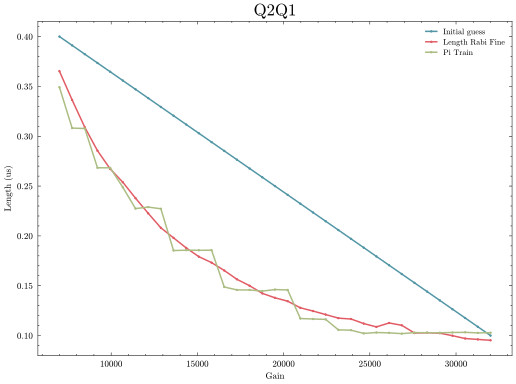

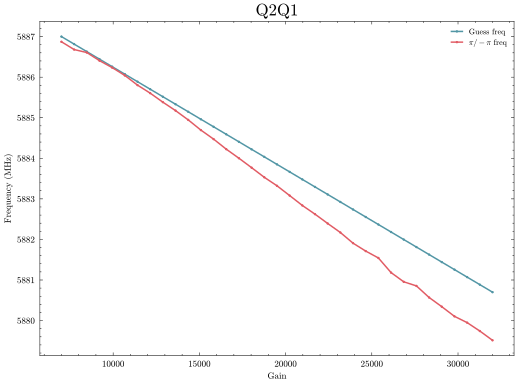

In [91]:
print(f'gain_sweep={np.array(gain_sweep).tolist()}')
print(f'new_opt_lens (fine length rabi)={new_opt_lens}')
print(f'new_opt_lens2 (error amp)={new_opt_lens2}')
print(f'new_opt_lens3 (pi train)={new_opt_lens3}')
print(f'opt_freqs (initial guess)={opt_freqs}')
print(f'new_opt_freqs={new_opt_freqs}')
print(f'saved_files_lengthrabi={saved_files_lengthrabi}')
print(f'saved_files_piminuspi={saved_files_piminuspi}')
print(f'saved_files_error_amp={saved_files_error_amp}')
print(f'saved_files_pitrain={saved_files_pitrain}')

plt.figure(figsize=(8, 6))
plt.plot(gain_sweep, opt_lens, '.-', label='Initial guess')
if do_length_rabi:
    plt.plot(gain_sweep, new_opt_lens, '.-', label='Length Rabi Fine')
if do_error_amp:
    plt.plot(gain_sweep, new_opt_lens2, '.-', label='Error Amplfication')
if do_pi_train:
    plt.plot(gain_sweep, new_opt_lens3, '.-', label='Pi Train')
plt.xlabel('Gain')
plt.ylabel('Length (us)')
plt.legend()
plt.title(f'Q{qubits[0]}Q{qubits[1]}')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(gain_sweep, opt_freqs, '.-', label='Guess freq')
if do_piminuspi:
    plt.plot(gain_sweep, new_opt_freqs, '.-', label='$\pi/-\pi$ freq')
plt.xlabel('Gain')
plt.ylabel('Frequency (MHz)')
plt.legend()
plt.title(f'Q{qubits[0]}Q{qubits[1]}')
plt.show()


### Replot data above

In [106]:
saved_files_lengthrabi = saved_files_lengthrabi[20:26]
saved_files_piminuspi = saved_files_piminuspi[20:26]
saved_files_error_amp = saved_files_error_amp[20:26]

In [42]:
# Reconstruct saved files list
saved_files_lengthrabi = []
saved_files_piminuspi = []
saved_files_error_amp = []

qubits = [3, 1]

start_i = 10
stop_i = 14
base_path = 's:\QRAM\qram_4QR2\data\data_241025'
filename = f'length_rabi_EgGf_qubit{qubits[0]}{qubits[1]}.h5'
for i in range(start_i, stop_i+1):
    if i < 10:
        saved_files_lengthrabi.append(f'{base_path}\\0000{i}_{filename}')
    elif i < 100:
        saved_files_lengthrabi.append(f'{base_path}\\000{i}_{filename}')
    else:
        saved_files_lengthrabi.append(f'{base_path}\\00{i}_{filename}')

start_i = 10
stop_i = 14
filename = f'PiMinusPiEgGfExptQ{qubits[0]}{qubits[1]}.h5'
for i in range(start_i, stop_i+1):
    if i < 10:
        saved_files_piminuspi.append(f'{base_path}\\0000{i}_{filename}')
    elif i < 100:
        saved_files_piminuspi.append(f'{base_path}\\000{i}_{filename}')
    else:
        saved_files_piminuspi.append(f'{base_path}\\00{i}_{filename}')

start_i = 10
stop_i = 14
filename = f'NPulseExptEgGfQ{qubits[0]}{qubits[1]}.h5'
for i in range(start_i, stop_i+1):
    if i < 10:
        saved_files_error_amp.append(f'{base_path}\\0000{i}_{filename}')
    elif i < 100:
        saved_files_error_amp.append(f'{base_path}\\000{i}_{filename}')
    else:
        saved_files_error_amp.append(f'{base_path}\\00{i}_{filename}')

In [ ]:
opt_fit_index = 0

new_opt_lens = []
new_opt_lens2 = []
new_opt_freqs = []

# Going through length rabi files again to get opt lens
for i_file, saved_file in enumerate(saved_files_lengthrabi):
    file_name = saved_file.split('\\')[-1]
    print(file_name)

    lengthrabiEgGf = meas.LengthRabiEgGfExperiment(config_file=config_path)
    # # rabiEgGfChevron.cfg.expt = dict(sigma_test=0.400, singleshot=False,)
    temp_data, attrs = prev_data(expt_path, file_name)
    lengthrabiEgGf.cfg = AttrDict(attrs['config'])
    lengthrabiEgGf.data = temp_data

    data = lengthrabiEgGf.analyze(fit=True)
    lengthrabiEgGf.display(fit=True)
    p, pcov = meas.fitting.get_best_fit(data, prefixes=['fitA', 'fitB'], check_measures=['amps'])
    if p[2] > 180:
        p[2] = p[2] - 360
    elif p[2] < -180:
        p[2] = p[2] + 360
    if p[2] < 0:
        pi_len = (1 / 2 - p[2] / 180) / 2 / p[1]
    else:
        pi_len = (3 / 2 - p[2] / 180) / 2 / p[1]

    new_opt_lens.append(pi_len)
    print('pi len', new_opt_lens[-1])


# Going through piminuspi files again to get opt freqs
for i_file, saved_file in enumerate(saved_files_piminuspi):
    file_name = saved_file.split('\\')[-1]
    print(file_name)

    piminuspi = meas.PiMinusPiEgGfExperiment(config_file=config_path)
    # # rabiEgGfChevron.cfg.expt = dict(sigma_test=0.400, singleshot=False,)
    temp_data, attrs = prev_data(expt_path, file_name)
    piminuspi.cfg = AttrDict(attrs['config'])
    piminuspi.data = temp_data

    data = piminuspi.analyze(fit=True)
    piminuspi.display(fit=True)
    best_freq = data['best_freq']
    new_opt_freqs.append(best_freq)
    print('best freq', new_opt_freqs[-1])


# Going through error amp files again to get opt lens 2
for i_file, saved_file in enumerate(saved_files_error_amp):
    file_name = saved_file.split('\\')[-1]
    print(file_name)

    npulsecalib = meas.NPulseEgGfExperiment(config_file=config_path)
    # # rabiEgGfChevron.cfg.expt = dict(sigma_test=0.400, singleshot=False,)
    temp_data, attrs = prev_data(expt_path, file_name)
    npulsecalib.cfg = AttrDict(attrs['config'])
    npulsecalib.data = temp_data

    data = npulsecalib.analyze(fit=True)
    npulsecalib.display(fit=True)

    npulsecalib_fit, npulsecalib_fit_err = meas.fitting.get_best_fit(npulsecalib.data, prefixes=['fitA', 'fitB'], check_measures=['avgi'])

    if np.all(npulsecalib_fit == data['fitA_avgi']): use_q =  npulsecalib.cfg.expt.measure_qubits[0]
    else: use_q = npulsecalib.cfg.expt.measure_qubits[1]
    if use_q == qDrive: sign = 1
    else: sign = -1
    angle_err = npulsecalib_fit[1]
    amp_ratio = (180 - sign*angle_err)/180
    new_opt_len = npulsecalib.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive] / amp_ratio

    print('pi len precise', new_opt_len, f'adjustment ratio {amp_ratio} from Q{use_q}')

    new_opt_lens2.append(new_opt_len)

In [ ]:
print(new_opt_lens)
print(saved_files)

In [ ]:
new_opt_lens[1] = 1.1987019004033739
new_opt_lens[4] = 0.4716335769416996

Sweep ramp times

In [ ]:
gain = 25066
freq = 5885.080333333333
default_len = 0.28170921764829654
default_sigma_ramp_cycles = 3
sigma_n = 4

# len_approx_gains = 1.5*np.linspace(0.470, 0.210, 25)
# # len_approx_gains = 1.5*np.linspace(0.500, 0.300, 21)
# print('max len for each gain (us)\n', len_approx_gains)


# freq_approx_gains = np.linspace(5889.675, 5882.583, 25) # approx freq for each gain
# # freq_approx_gains = np.linspace(5151.5, 5147, 21) # approx freq for each gain

sigma_ramp_cycle_sweep = np.linspace(2, 20, 10)
sigma_ramp_us_sweep = np.array([soc.cycles2us(c, gen_ch=yaml_cfg.hw.soc.dacs.swap_Q.ch[sweep2Q_q]) for c in sigma_ramp_cycle_sweep])
print('sigma_ramp_cycle_sweep', sigma_ramp_cycle_sweep)
print('sigma_ramp in ns', 1e3*sigma_ramp_us_sweep)


default_area = default_len * gain + np.sqrt(2*np.pi)*soc.cycles2us(default_sigma_ramp_cycles, gen_ch=yaml_cfg.hw.soc.dacs.swap_Q.ch[sweep2Q_q])*sp.special.erf(sigma_n/2 / np.sqrt(2))
expected_flat_len = (default_area - np.sqrt(2*np.pi)*sigma_ramp_us_sweep*sp.special.erf(sigma_n/2 / np.sqrt(2))) / gain

print('expected_flat_lens', expected_flat_len)


# print('approx freq for each gain\n', freq_approx_gains)

# opt_lens = []
# opt_freqs = []
# saved_files = []
# save_files = True

# opt_fit_index = 2 # index of [QA I, QA Q, QB I, QB Q] to use as saved optimal

In [ ]:
saved_files = []
save_files = True
opt_lens_ramps = []
opt_fit_index = 2

for i_ramp, ramp_cycles in enumerate(sigma_ramp_cycle_sweep):
    lengthrabiEgGf = meas.LengthRabiEgGfExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"length_rabi_EgGf_qubit{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )
    
    stop_len = default_len*1.5

    start_len = 0
    span_len = stop_len - start_len
    npts_len = 151

    sweep2Q_q = qubits[0]
    lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q] = int(gain)
    lengthrabiEgGf.cfg.device.qubit.f_EgGf_Q[sweep2Q_q] = freq

    lengthrabiEgGf.cfg.expt = dict(
        start=start_len, # pulse length (sigma) [us]
        step=span_len/npts_len, # [us]
        expts=npts_len,
        reps=2000,
        post_process='threshold',
        # post_process=None,
        singleshot_reps=20000,
        measure_f=False,
        init_state=init_state,
        qDrive=qDrive,
        qubits=qubits,
        measure_qubits=measure_qubits,
        sigma_ramp_cycles=ramp_cycles,
    )
    
    # lengthrabiEgGf.cfg.device.readout.readout_length = [10,5] # [us]
    print(lengthrabiEgGf.cfg)
    # lengthrabiEgGf.im[lengthrabiEgGf.cfg.aliases.soc].reset()
    try:
        lengthrabiEgGf.acquire(progress=True, debug=True)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    if save_files: saved_files.append(lengthrabiEgGf.save_data())
    print('Saved', saved_files[-1])
    data = lengthrabiEgGf.analyze(data=None, fit=True)
    pi_lens = lengthrabiEgGf.display(data=data, fit=True)

    new_opt_lens.append(pi_lens[opt_fit_index])
    print('pi len', new_opt_lens[-1])

## Randomized benchmarking

In [ ]:
rbprog = meas.SimultaneousRBEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

gate_char = None
# gate_char = 'X'


max_gates = 225
expts = 30
# expts = 5

if gate_char is None: step = max_gates // expts
else: step = max_gates // (2*expts)
print('step', step)

rbprog.cfg.expt = dict(
    # start=20,
    # step=0,
    # expts=1,
    # variations=1000,
    # variations=10, # number different sequences per depth
    start=1, # rb depth start
    step=step, # step rb depth
    expts=expts+1, # number steps
    # variations=3,
    variations=20,
    reps=2000, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    loops=5,
    # reps=100, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=qubits,
    qDrive=qDrive,
    singleshot_reps=20000, # reps per state for singleshot calibration
    # singleshot_reps=100, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

    measure_f=[qDrive],
    add_phase=True,

    # cool_qubits=[0, 1],

)
# rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
# rbprog.cfg.device.readout.relax_delay = 1
# rbprog.cfg.device.readout.readout_length = 5

print(rbprog.cfg)

try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
rbprog.save_data()

In [ ]:
# # TESTING
rbprog = meas.SimultaneousRBEgGfExperiment(config_file=config_path)
temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240617\\00011_rb_EgGf_qubit31.h5')
rbprog.data = temp_data
rbprog.cfg = AttrDict(attrs['config'])
rbprog.calib_order = attrs['calib_order']

rbprog.analyze(fit=True)
# rbprog.display(fit=True, show_all_vars=False)

In [ ]:
rbprog.save_data()

In [ ]:
# p_irb = 0.9590834452029213 
# p_irb_err = 0.0002387037509980582
# p_rb = 0.9833366468001751 
# p_rb_err = 0.00011879294449350527

p_irb = 0.9378643954169977
p_irb_err = 0.02184963356373672
p_rb = 0.9736931040310971
p_rb_err = 0.01541381511169818 
print(100*meas.fitting.rb_error(p_rb, 2),'% average error')
gate_fid, gate_fid_err = meas.fitting.rb_gate_fidelity(p_rb=p_rb, p_irb=p_irb, d=2, p_rb_err=p_rb_err, p_irb_err=p_irb_err)
print(100*gate_fid, '+/-', 100*gate_fid_err, '% gate fidelity')

In [ ]:
rbprog = meas.SimultaneousRBEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

# gate_char = None
gate_char = 'X'


max_gates = 225
expts = 30
# expts = 5

if gate_char is None: step = max_gates // expts
else: step = max_gates // (2*expts)
print('step', step)

rbprog.cfg.expt = dict(
    # start=20,
    # step=0,
    # expts=1,
    # variations=1000,
    # variations=10, # number different sequences per depth
    start=1, # rb depth start
    step=step, # step rb depth
    expts=expts+1, # number steps
    variations=20,
    reps=2000, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    loops=5,
    # reps=5, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=qubits,
    qDrive=qDrive,
    singleshot_reps=20000, # reps per state for singleshot calibration
    # singleshot_reps=100, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

    measure_f=[qDrive],
    add_phase=True,

    # cool_qubits=[0, 1],

)
# rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
# rbprog.cfg.device.readout.relax_delay = 1
# rbprog.cfg.device.readout.readout_length = 5

print(rbprog.cfg)

try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
rbprog.save_data()

In [ ]:
# # TESTING
# rbprog = meas.SimultaneousRBEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240617\\00010_rb_EgGf_qubit21.h5')
# rbprog.data = temp_data
# rbprog.cfg = AttrDict(attrs['config'])
# rbprog.calib_order = attrs['calib_order']

rbprog.analyze(fit=True)
rbprog.display(fit=True, show_all_vars=False)

Q2/Q1


In [ ]:
qubits = [2, 1] # order doesn't matter if you specify qDrive correctly
init_state = '|0>|1>'
setup_ZZ = None
# measure_qubits = [qubits[0], qubits[1], 3]
measure_qubits = qubits
qDrive = qubits[0] # normal new protocol

In [ ]:
rbprog = meas.SimultaneousRBEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

gate_char = None
# gate_char = 'X'


max_gates = 225
expts = 30
# expts = 5

if gate_char is None: step = max_gates // expts
else: step = max_gates // (2*expts)
print('step', step)

rbprog.cfg.expt = dict(
    # start=20,
    # step=0,
    # expts=1,
    # variations=1000,
    # variations=10, # number different sequences per depth
    start=1, # rb depth start
    step=step, # step rb depth
    expts=expts+1, # number steps
    variations=20,
    reps=2000, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    loops=5,
    # reps=5, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=qubits,
    qDrive=qDrive,
    singleshot_reps=20000, # reps per state for singleshot calibration
    # singleshot_reps=100, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

    measure_f=[qDrive],
    add_phase=True,

    # cool_qubits=[0, 1],

)
# rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
# rbprog.cfg.device.readout.relax_delay = 1
# rbprog.cfg.device.readout.readout_length = 5

print(rbprog.cfg)

try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
rbprog.save_data()

In [ ]:
# # TESTING
# rbprog = meas.SimultaneousRBEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240617\\00010_rb_EgGf_qubit21.h5')
# rbprog.data = temp_data
# rbprog.cfg = AttrDict(attrs['config'])
# rbprog.calib_order = attrs['calib_order']

rbprog.analyze(fit=True)
rbprog.display(fit=True, show_all_vars=False)

In [ ]:
rbprog = meas.SimultaneousRBEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

# gate_char = None
gate_char = 'X'


max_gates = 225
expts = 30
# expts = 5

if gate_char is None: step = max_gates // expts
else: step = max_gates // (2*expts)
print('step', step)

rbprog.cfg.expt = dict(
    # start=20,
    # step=0,
    # expts=1,
    # variations=1000,
    # variations=10, # number different sequences per depth
    start=1, # rb depth start
    step=step, # step rb depth
    expts=expts+1, # number steps
    variations=20,
    reps=2000, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    loops=5,
    # reps=5, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=qubits,
    qDrive=qDrive,
    singleshot_reps=20000, # reps per state for singleshot calibration
    # singleshot_reps=100, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

    measure_f=[qDrive],
    add_phase=True,

    # cool_qubits=[0, 1],

)
# rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
# rbprog.cfg.device.readout.relax_delay = 1
# rbprog.cfg.device.readout.readout_length = 5

print(rbprog.cfg)

try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
rbprog.save_data()

In [ ]:
# # TESTING
# rbprog = meas.SimultaneousRBEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240617\\00010_rb_EgGf_qubit21.h5')
# rbprog.data = temp_data
# rbprog.cfg = AttrDict(attrs['config'])
# rbprog.calib_order = attrs['calib_order']

rbprog.analyze(fit=True)
rbprog.display(fit=True, show_all_vars=False)

## 3D sweep to optimize length, gain, freq

In [ ]:
2027 - np.arange(expts_gain)*(10/8000*step_gain)

In [ ]:
start_gain = 2000
step_gain = 2000
expts_gain = 5
gain_sweep = start_gain + step_gain * np.arange(expts_gain)
print(gain_sweep)

sweep2d_expt_progs = []

for ig, gain in enumerate(gain_sweep):
    print('Now setting gain to', gain)
    rabiEgGfFreqLenChevron = meas.EgGfFreqLenChevronExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"rabi_EgGf_freqlen_chevron_qubit{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )

    span_f = 6 # MHz
    npts_f = 20

    freq_center_pts = 2412 - np.arange(expts_gain)*(10/6000*step_gain)
    if ig==0: print('Freq sweep will be centered at', freq_center_pts)

    rabiEgGfFreqLenChevron.cfg.expt = dict(
        start_f=freq_center_pts[ig] - span_f/2,
        step_f=span_f/npts_f, # freq step, 
        expts_f=npts_f, # number of different freq experiments, 
        start_len=soc.cycles2us(10), # pulse length (sigma) [us]
        step_len=soc.cycles2us(12), # [us]
        expts_len=30,
        gain=gain,
        reps=1000,
        pulse_type='flat_top',
        post_process='scale',
        singleshot_reps=15000,
        qubits=qubits,
    )

    # rabiEgGfFreqLenChevron.cfg.device.readout.readout_length = [15, 15] # [us]
    # rabiEgGfFreqLenChevron.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

    # print(rabiEgGfFreqLenChevron.cfg)

    try:
        rabiEgGfFreqLenChevron.go(analyze=False, display=False, progress=True, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))
    
    rabiEgGfFreqLenChevron.analyze(data=None)
    rabiEgGfFreqLenChevron.display(data=None)
    sweep2d_expt_progs.append(rabiEgGfFreqLenChevron)

# Crosstalk calibrations

In [ ]:
crosstalkEcho = meas.CrosstalkEchoExperiment(
    soccfg=soc,
    path=expt_path,
    config_file=config_path,
)

crosstalkEcho.cfg.expt = dict(
    start=soc.cycles2us(60), # wait time tau [us]
    step=soc.cycles2us(90), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=soc.cycles2us(15), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    expts=200,
    ramsey_freq=0.0, # [MHz]
    cpmg=False, # cp or cpmg
    reps=1500,
    qTest=1,
    qDrives=[2, 3],
    gain_x=10000,
    gain_y=0,
)
print(crosstalkEcho.cfg.expt.step)

print(crosstalkEcho.cfg)

try:
    crosstalkEcho.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# crosstalkEcho = meas.RamseyExperiment(config_file=config_path)
# crosstalkEcho.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit1.h5')
# data = crosstalkEcho.analyze(data=temp_data, fit=True)
# crosstalkEcho.display(data=data, fit=True)

data = crosstalkEcho.data
fitparams=[None, 5/data['xpts'][-1], None, None, None]
crosstalkEcho.analyze(fit=False, fit_num_sin=1, fitparams=fitparams)
crosstalkEcho.display(fit=False, fit_num_sin=1)

qTest = crosstalkEcho.cfg.expt.qTest

data = crosstalkEcho.data
xpts = data['xpts']
fourier = np.fft.fftshift(np.abs(np.fft.fft(data['avgi'])))
freqs = np.fft.fftshift(np.fft.fftfreq(len(fourier), d=(xpts[1]-xpts[0])))
plt.plot(freqs, fourier)
plt.xlabel('Frequency [MHz]')
plt.xlim(-6, 6)
# plt.ylim(0, 20000)
plt.title(f'Fourier Transform of Ramsey Echo on Q{qTest} (Ramsey Freq: {crosstalkEcho.cfg.expt.ramsey_freq})')
plt.show()

In [ ]:
# # TESTING
# t2r = meas.RamseyExperiment(config_file=config_path)
# t2r.cfg.expt = dict(ramsey_freq=2, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit1.h5')
# data = t2r.analyze(data=temp_data, fit=True)
# t2r.display(data=data, fit=True)

t2r.save_data()

## Chevron for gain sweep vs time sweep

In [ ]:
crosstalkEchoTimeChevron = meas.CrosstalkEchoTimeChevronExperiment(
    soccfg=soc,
    path=expt_path,
    config_file=config_path,
)

span_i = 40000
npts_i = 150


crosstalkEchoTimeChevron.cfg.expt = dict(
    start_i=-span_i//2,
    step_i=int(span_i/npts_i), # [dac level]
    expts_i=npts_i+1,
    # start_t=soc.cycles2us(60), # wait time tau [us]
    # step_t=soc.cycles2us(30), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # expts_t=250,
    start_t=3.5,
    step_t=0,
    expts_t=1,
    sweep_axis='x',
    ramsey_freq=0.0, # [MHz]
    cpmg=False, # cp or cpmg
    reps=4000,
    qTest=1,
    qDrives=[2, 3],
    post_process='scale',
    singleshot_reps=20000,
    thresholds=[0, 42.250179073420334, 0, 0],
    angles=[0, -27.653262746238827, 0, 0],
    ge_avgs=[array([0., 0., 0., 0.]), [29.582075536759927, 24.37702111255693, 38.68021955107352, 29.11635689655172], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
    counts_calib=[[8046, 6063, 3431, 2460], [3095, 2322, 8364, 6219]]
)

print(crosstalkEchoTimeChevron.cfg)

try:
    crosstalkEchoTimeChevron.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240218\\00002_CrosstalkEchoTime.h5', filename=None)
crosstalkEchoTimeChevron.data = temp_data
crosstalkEchoTimeChevron.cfg = AttrDict(attrs['config'])
print(crosstalkEchoTimeChevron.cfg.expt)

crosstalkEchoTimeChevron.analyze(fit=True)
crosstalkEchoTimeChevron.display(fit=True)

data = crosstalkEchoTimeChevron.data
plt.figure()
t_ind = np.argmin(np.abs(data['wait_times']-3))
# e_val = np.min(data['amps'])
# g_val = np.max(data['amps'])
plt.plot(data['gain_i_sweep'], data['amps'][:,t_ind], 'o-')
plt.title(f'Crosstalk Calibration on Q{crosstalkEchoTimeChevron.qTest} with drive on {crosstalkEchoTimeChevron.qDrives}')
plt.xlabel(f'Gains ({crosstalkEchoTimeChevron.cfg.expt.sweep_axis} axis) (DAC units)')
plt.ylabel('Population')
plt.axvline(0)
plt.axvline(12500)
plt.axvline(17750)
plt.axvline(-12500)
plt.axvline(-17750)
plt.show()

In [ ]:
crosstalkEchoTimeChevron.save_data()

## Chevron for fixed time

In [ ]:
crosstalkEchoChevron = meas.CrosstalkEchoChevronExperiment(
    soccfg=soc,
    path=expt_path,
    config_file=config_path,
)

span_x = 40000
npts_x = 60

span_y = 40000
npts_y = 60

crosstalkEchoChevron.cfg.expt = dict(
    start_x=-span_x//2,
    step_x=int(span_x/npts_x), # [dac level]
    expts_x=npts_x,
    start_y=-span_y//2,
    step_y=int(span_y/npts_y), # [dac level]
    expts_y=npts_y,
    ramsey_freq=0.0, # [MHz]
    cpmg=False, # cp or cpmg
    reps=2000,
    qTest=1,
    qDrives=[2, 3],
    wait_us=4,
    post_process='scale',
)

print(crosstalkEchoChevron.cfg)

try:
    crosstalkEchoChevron.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
data = crosstalkEchoChevron.data
for k, a in data.items():
    data[k]=np.array(a)
    if np.shape(data[k]) == (100,):
        data[k] = np.reshape(data[k], (10, 10))
crosstalkEchoChevron.analyze(fit=True)
crosstalkEchoChevron.display(fit=True)